In [4]:
suppressPackageStartupMessages({
library(dplyr)
library(ggpubr)
library(ggplot2)
library(tidyverse)
library(data.table)
library(biomaRt)
     library(survival)
    library(biomaRt)
    library(survminer)
      library(GEOquery)
    })

In [5]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

## Read the dataset from GSE62564

In [3]:
gse <- readRDS('/scratch/gpfs/KANG/hirak/mendel/Projects/neuroblastoma_analysis/survival/GSE62564_info.rds')
pdata = pData(gse)
fset = fData(gse)
eset <- exprs(gse)
vals = c('title', "os day:ch1" ,"os bin:ch1", "efs day:ch1", "efs bin:ch1", "age:ch1", "Sex:ch1")

In [4]:
metadata = pdata %>% dplyr::select(vals)
metadata$title <- gsub(" \\[.*\\]", "", metadata$title)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(vals)

  # Now:
  data %>% select(all_of(vals))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [5]:
colnames(metadata) = c('title', 'OS.days', 'OS.event', 'EFS.days', 'EFS.event', 'age', 'gender')

In [6]:
expr_gse <- readRDS('/scratch/gpfs/KANG/hirak/mendel/Projects/neuroblastoma_analysis/survival/GSE49710_info.rds')

In [7]:
expr_data = exprs(expr_gse)

In [8]:
fData(expr_gse) %>% dplyr::select(c("ID", "GeneSymbol")) %>%
    mutate(`GeneSymbol` = sapply(strsplit(as.character(`GeneSymbol`), " /// "), `[`, 1)) %>%
    filter(!is.na(`GeneSymbol`)) %>% dim

[1] 31145     2

In [9]:
risk_metadata = readRDS(
    '/scratch/gpfs/KANG/hirak/mendel/Projects/neuroblastoma_analysis/survival/GSE49710_survival_processed.rds'
)$metadata

In [10]:
risk_metadata %>% head

,title,death,risk,stage,progression,gender,tissue,age,OS.days,OS.event,EFS.days,EFS.event,age2,gender2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SEQC_NB001,1,1,4,1,M,Neuroblastoma,987,1362,1,593,1,987,M
2,SEQC_NB002,1,1,4,1,M,Neuroblastoma,1808,2836,1,2016,1,1808,M
3,SEQC_NB003,1,1,4,1,F,Neuroblastoma,625,1191,1,840,1,625,F
4,SEQC_NB004,0,1,2,0,F,Neuroblastoma,335,2046,0,2046,0,335,F
5,SEQC_NB005,1,1,4,1,F,Neuroblastoma,536,220,1,212,1,536,F
6,SEQC_NB006,0,0,4S,0,M,Neuroblastoma,147,2217,0,2217,0,147,M


In [11]:
risk_metadata[,c('title', 'risk')] %>% head 

,title,risk
,<chr>,<chr>
1,SEQC_NB001,1
2,SEQC_NB002,1
3,SEQC_NB003,1
4,SEQC_NB004,1
5,SEQC_NB005,1
6,SEQC_NB006,0


In [12]:
fdata_filtered = fData(expr_gse) %>% dplyr::select(c("ID", "GeneSymbol")) %>%
    mutate(`GeneSymbol` = sapply(strsplit(as.character(`GeneSymbol`), " /// "), `[`, 1)) %>%
    filter(!is.na(`GeneSymbol`))
expr_data = expr_data[ fdata_filtered%>% rownames, ]
rownames(expr_data) = fdata_filtered$`GeneSymbol`

In [13]:
survival_data = read.csv('survival_data.csv')

In [14]:
metadata$time = round(as.numeric(metadata$OS.days)/30,0)
metadata$vital_status = as.numeric(metadata$OS.event)

In [15]:
metadata = merge(metadata, survival_data[,c("Sample.ID", "mycn_status")], by.x = "title", by.y = "Sample.ID")

In [16]:
metadata = merge(metadata,risk_metadata[,c('title', 'risk')],by = 'title')

In [17]:
metadata$mycn_status <- as.numeric(metadata$mycn_status)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [18]:
table(metadata$mycn_status)


  0   1 
401  92 

In [1]:
401 + 92

[1] 493

In [19]:
metadata %>% dim

[1] 498  11

In [20]:
metadata %>% head

,title,OS.days,OS.event,EFS.days,EFS.event,age,gender,time,vital_status,mycn_status,risk
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,SEQC_NB001,1362,1,593,1,987,M,45,1,0,1
2,SEQC_NB002,2836,1,2016,1,1808,M,95,1,0,1
3,SEQC_NB003,1191,1,840,1,625,F,40,1,1,1
4,SEQC_NB004,2046,0,2046,0,335,F,68,0,1,1
5,SEQC_NB005,220,1,212,1,536,F,7,1,1,1
6,SEQC_NB006,2217,0,2217,0,147,M,74,0,0,0


In [27]:
metadata.mycn = metadata %>% filter(mycn_status == 1)

In [29]:
#expr_metadata[metadata$mycn_status == 0,] %>% dim

In [43]:
gs = sig_groups_list$`Neurite outgrowth`
gs = intersect(gs, rownames(expr_data))
if(length(gs) == 0){
    return (NULL)
}
tmp = expr_data[gs,]
score = scale(rowMeans(t(tmp)))
expr_metadata = cbind(data.frame("gene.Z" = score), metadata)
expr_metadata_mycn = expr_metadata[metadata$mycn_status == 1,]

## plot histogram

In [44]:
expr_metadata_mycn = na.omit(expr_metadata_mycn)

In [45]:
expr_metadata_mycn %>% head

,gene.Z,title,OS.days,OS.event,EFS.days,EFS.event,age,gender,time,vital_status,mycn_status,risk
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
GSM1205240,-0.2078667,SEQC_NB003,1191,1,840,1,625,F,40,1,1,1
GSM1205241,0.7913512,SEQC_NB004,2046,0,2046,0,335,F,68,0,1,1
GSM1205242,-0.4797627,SEQC_NB005,220,1,212,1,536,F,7,1,1,1
GSM1205245,0.9952732,SEQC_NB008,3526,0,3526,0,1652,M,118,0,1,1
GSM1205246,0.6350110,SEQC_NB009,2306,0,2306,0,217,F,77,0,1,1
GSM1205247,1.7090003,SEQC_NB010,1081,1,620,1,379,M,36,1,1,1


In [46]:
expr_metadata_mycn$exprStatus <- ifelse(expr_metadata_mycn$gene.Z > 0, 1,
                                ifelse(expr_metadata_mycn$gene.Z < 0, 0, 2))

In [47]:
expr_metadata_mycn <- expr_metadata_mycn[expr_metadata_mycn$exprStatus != 2,]
expr_metadata_mycn$risk = as.numeric(expr_metadata_mycn$risk)

In [48]:
expr_metadata_mycn %>% dim

[1] 92 13

In [49]:

fit <- do.call(survfit, list(Surv(eval(parse(text = "time")), eval(parse(text = "risk"))) ~ exprStatus, 
                                 data = expr_metadata_mycn[c("time", "risk", "exprStatus")] ))

diff <- survdiff(formula = Surv(eval(parse(text="time")), eval(parse(text="risk"))) ~ exprStatus, 
                 data = expr_metadata_mycn[c("time", "risk", "exprStatus")]  )

pval <- pchisq(diff$chisq, length(diff$n)-1, lower.tail = FALSE)

adjpval <- p.adjust(pval, method = "fdr",  n = (fit$n[1] + fit$n[2]))

In [2]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.10 (Ootpa)

Matrix products: default
BLAS/LAPACK: /scratch/gpfs/KANG/hirak/mambaforge/envs/r43/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] digest_0.6.35   IRdisplay_1.1   utf8_1.2.4      base64enc_0.1-3
 [5] fastmap_1.1.1   glue_1.7.0      htmltools_0.5.7 repr_1.1.6     
 [9] lifecycle_1.0.4 cli_3.6.2       

In [50]:
run_surv_mycn = function(
    gs,celltype
){
    gs = intersect(gs, rownames(expr_data))
    if(length(gs) == 0){
        return (NULL)
    }
    tmp = expr_data[gs,]
    score = scale(rowMeans(t(tmp)))
    expr_metadata = cbind(data.frame("gene.Z" = score), metadata)
    expr_metadata_mycn = expr_metadata[metadata$mycn_status == 1,]
    expr_metadata_mycn = na.omit(expr_metadata_mycn)

    ## plot histogram
    percentiles <- quantile(expr_metadata_mycn$gene.Z, probs = c(0.25, 0.75))
    hist(expr_metadata_mycn$gene.Z)
    abline(v = percentiles[1], col = "red", lty = 2)
    abline(v = percentiles[2], col = "red", lty = 2)

    expr_metadata_mycn$exprStatus <- ifelse(expr_metadata_mycn$gene.Z > 0, 1,
                                ifelse(expr_metadata_mycn$gene.Z < 0, 0, 2))

    expr_metadata_mycn <- expr_metadata_mycn[expr_metadata_mycn$exprStatus != 2,]
    expr_metadata_mycn$risk = as.numeric(expr_metadata_mycn$risk)

    # expr_metadata = expr_metadata[!is.na(expr_metadata$mycn_status),]

    fit <- do.call(survfit, list(Surv(eval(parse(text = "time")), eval(parse(text = "risk"))) ~ exprStatus, 
                                 data = expr_metadata_mycn[c("time", "risk", "exprStatus")] ))

    diff <- survdiff(formula = Surv(eval(parse(text="time")), eval(parse(text="risk"))) ~ exprStatus, 
                     data = expr_metadata_mycn[c("time", "risk", "exprStatus")]  )

    pval <- pchisq(diff$chisq, length(diff$n)-1, lower.tail = FALSE)

    adjpval <- p.adjust(pval, method = "fdr",  n = (fit$n[1] + fit$n[2]))

    plotTitle <- paste0(celltype,"-", paste(gs, collapse = " | "), " P-val(Adj) :", 
                        format(pval, scientific=T, digits=3), "(", format(adjpval, scientific=T, digits=3), ")")

    low <- paste0("Low : n = ", fit$n[1])
    high <- paste0("High : n = ", fit$n[2])
    names(fit$strata) <- c(low,high)

    fig.size(8,6)
    plot <- ggsurvplot(fit,
                 data = expr_metadata_mycn,
                 pval = TRUE,
                 pval.size = 5,
                 conf.int = TRUE,
                 risk.table = TRUE, # Add risk table
                 risk.table.col = "strata", # Change risk table color by groups
                 surv.median.line = "hv", # Specify median survival
                 ggtheme = theme_bw(base_size = 14), # Change ggplot2 theme
                 risk.table.fontsize = 5,
                 palette = c("#E7B800", "#2E9FDF"),
                 title = plotTitle) + xlab('Survival Time')
    
    ggsave(
        glue::glue(
            '/scratch/gpfs/KANG/hirak/mendel/Projects/neuroblastoma_analysis/',
            paste0('results/figures/2024/survival_plot_mycn/',celltype,'.pdf')
        ),
        plot = plot$plot, 
        height = 6,
        width = 6,
        create.dir=TRUE
    )
    return(plot)
}

In [6]:
signature.df = openxlsx::read.xlsx(
    '../spread_sheet/Figure5_20240214_No_6-50_Organoids_survival_signatures.xlsx'
)
sig_groups = signature.df %>% 
    group_by(Annotation) %>%
    summarize(ValueList = list(Human.Gene), .groups = 'drop')
sig_groups_list = sig_groups$ValueList
names(sig_groups_list) = sig_groups$Annotation

In [7]:
sig_groups_list

$`Neurite outgrowth`
[1] "FDPS" "SOD1" "PGK1" "TBCA"

$`Neuronal Differentiation`
[1] "CRABP1" "ASS1"   "NOS1"   "HMX3"  

$`S phase Sympathoblasts`
[1] "BAIAP2" "FBXO5"  "CCNE1"  "DDIT4"  "CDKN1A"

$`Synaptic signaling`
[1] "TSIX"  "KTN1"  "NSD1"  "DHX36"

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”


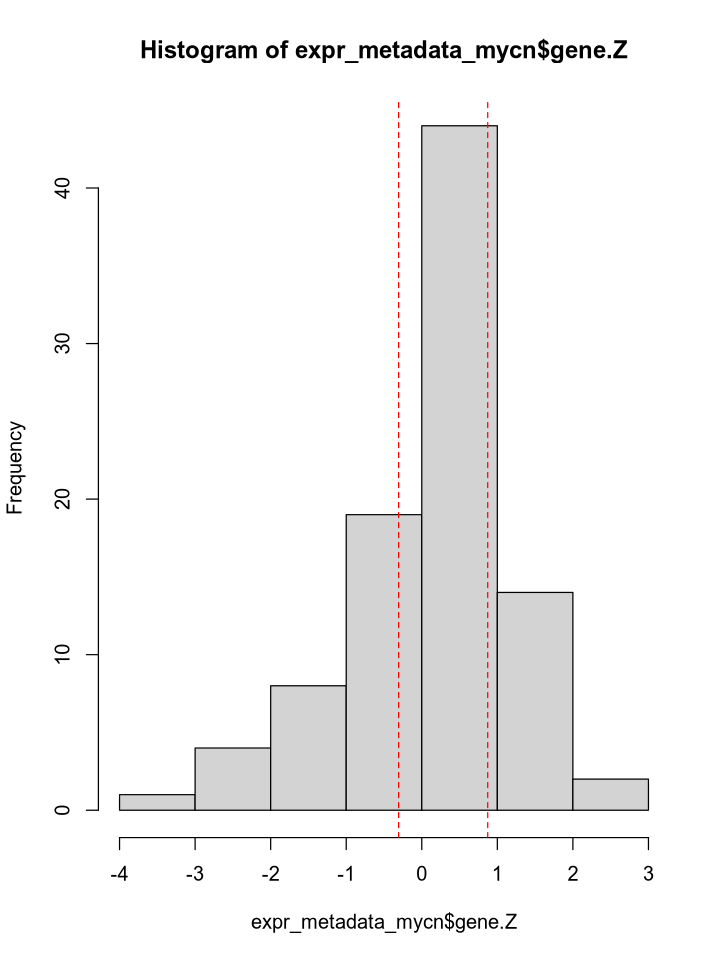

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”


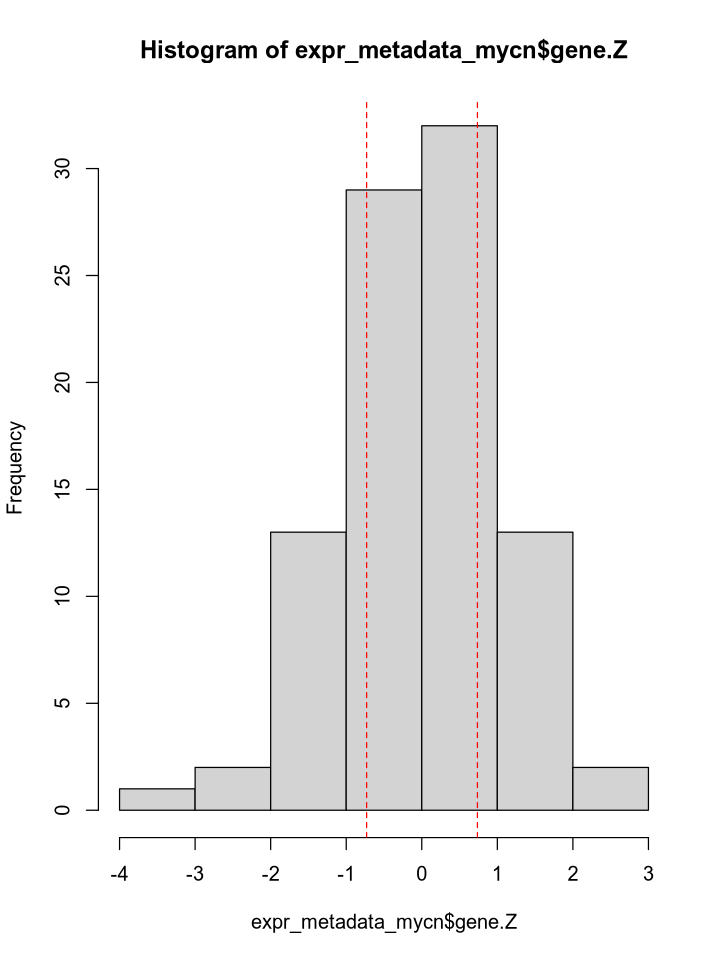

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”


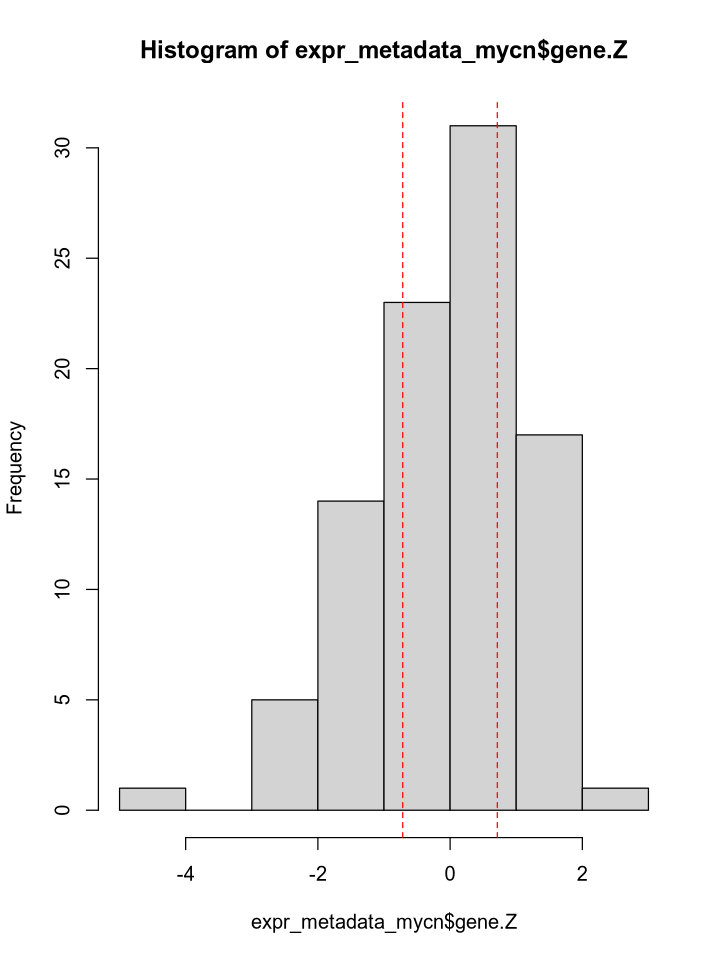

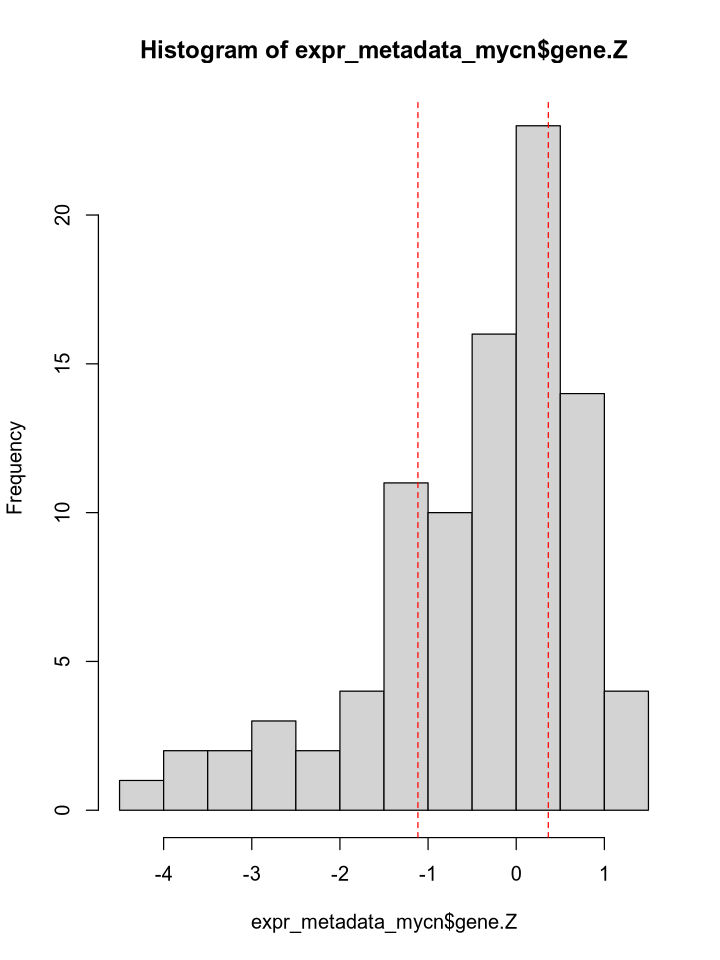

In [54]:
plot.list.mycn = list()

for(celltype in names(sig_groups_list)){
    plot.list.mycn[[celltype]] = run_surv_mycn(sig_groups_list[[celltype]],celltype)
}

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”


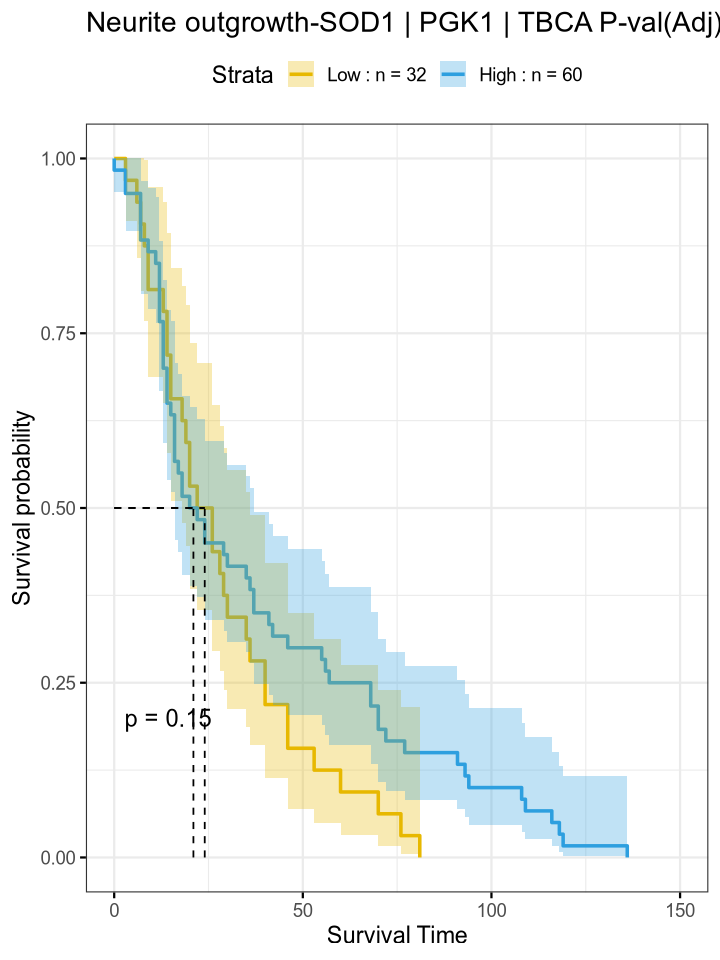

In [56]:
plot.list.mycn$`Neurite outgrowth`$plot

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”


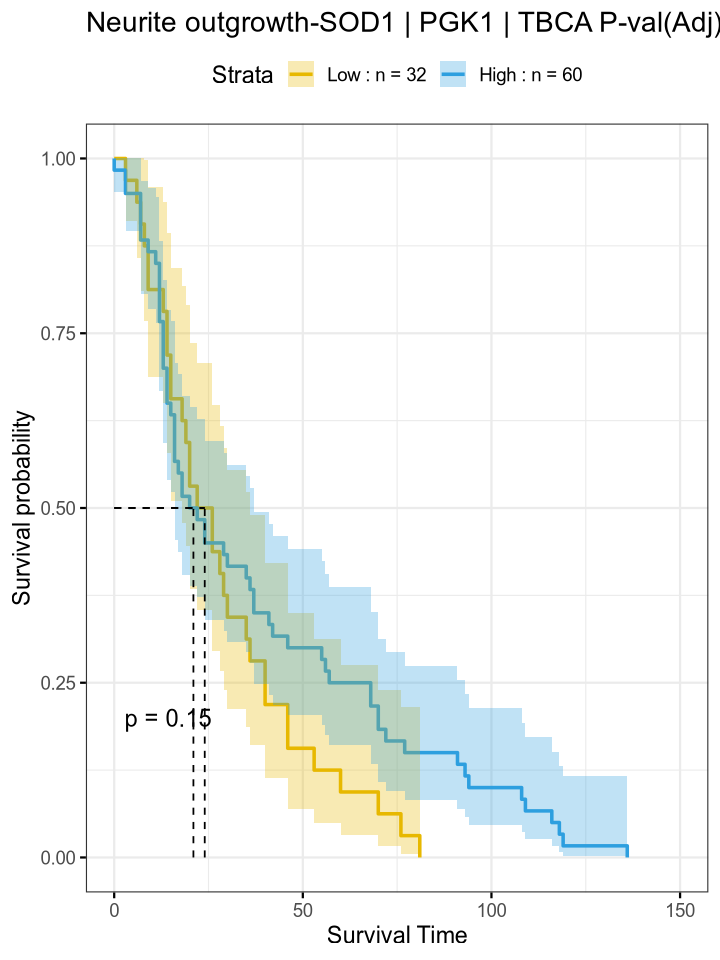

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”


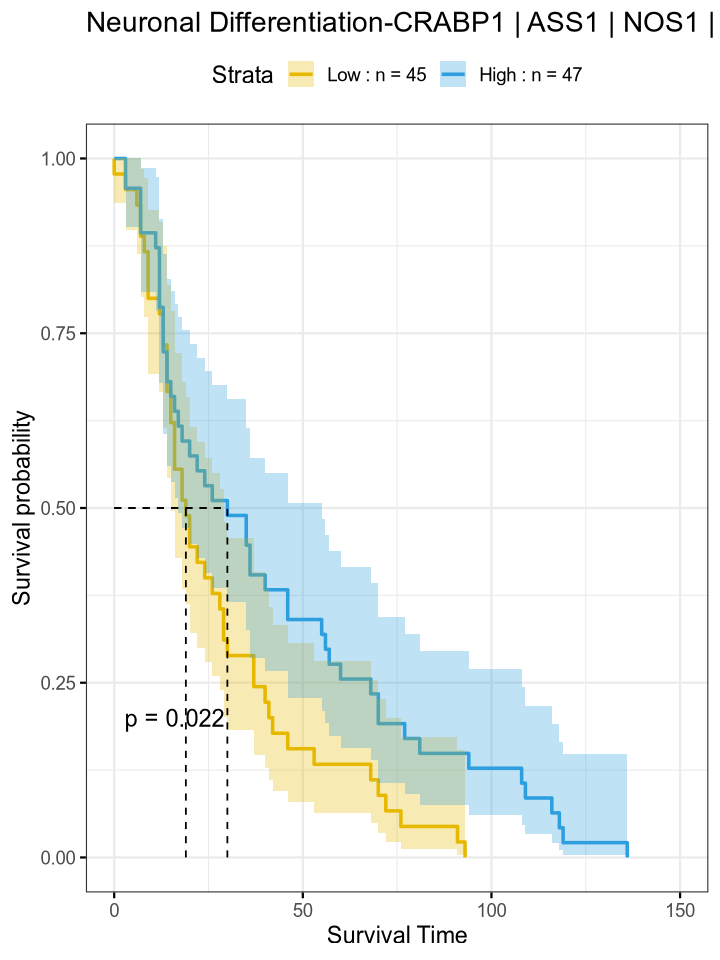

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”


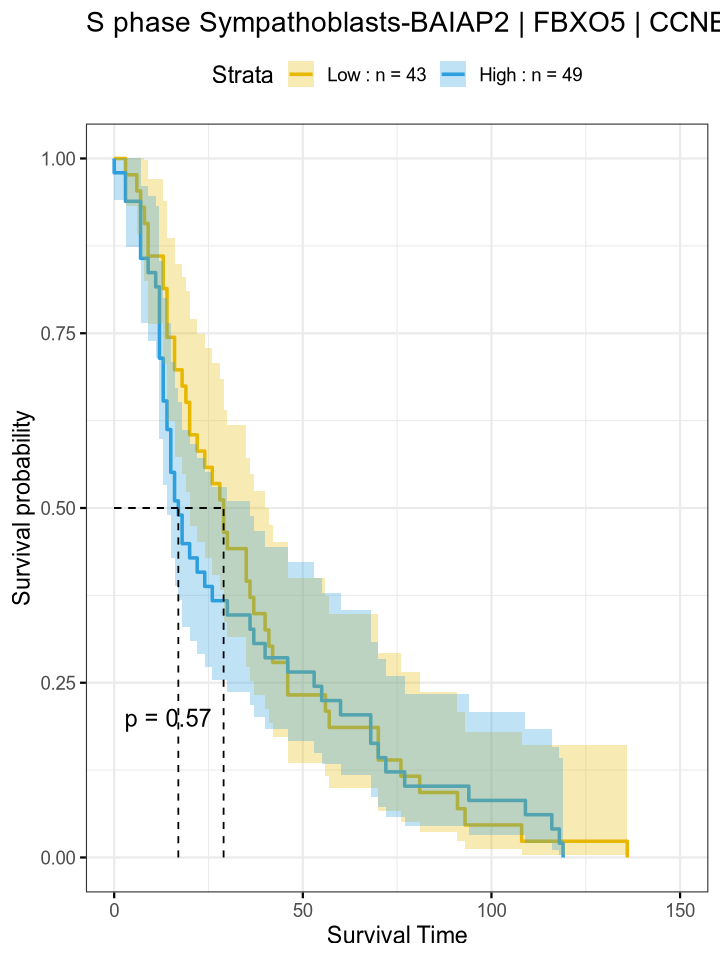

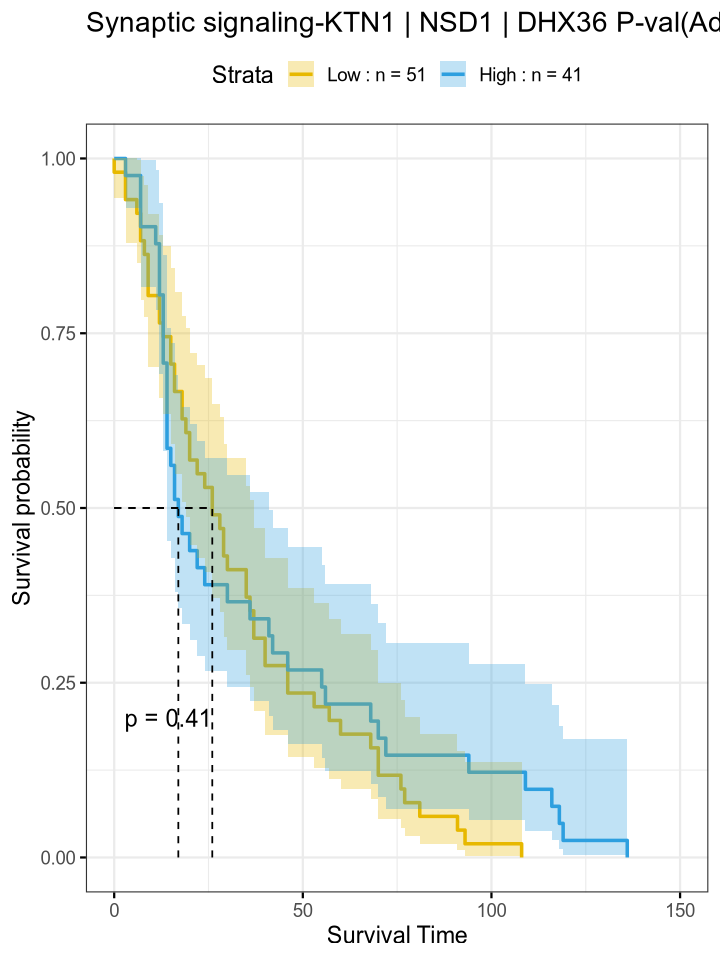

In [61]:
for (cell_type in names(plot.list.mycn)){
    print(plot.list.mycn[[cell_type]]$plot)
}

In [62]:
run_surv_no_mycn = function(
    gs,celltype
){
    gs = intersect(gs, rownames(expr_data))
    if(length(gs) == 0){
        return (NULL)
    }
    tmp = expr_data[gs,]
    score = scale(rowMeans(t(tmp)))
    expr_metadata = cbind(data.frame("gene.Z" = score), metadata)
    expr_metadata_mycn = expr_metadata[metadata$mycn_status == 0,]
    expr_metadata_mycn = na.omit(expr_metadata_mycn)

    ## plot histogram
    percentiles <- quantile(expr_metadata_mycn$gene.Z, probs = c(0.25, 0.75))
    hist(expr_metadata_mycn$gene.Z)
    abline(v = percentiles[1], col = "red", lty = 2)
    abline(v = percentiles[2], col = "red", lty = 2)

    expr_metadata_mycn$exprStatus <- ifelse(expr_metadata_mycn$gene.Z > 0, 1,
                                ifelse(expr_metadata_mycn$gene.Z < 0, 0, 2))

    expr_metadata_mycn <- expr_metadata_mycn[expr_metadata_mycn$exprStatus != 2,]
    expr_metadata_mycn$risk = as.numeric(expr_metadata_mycn$risk)

    # expr_metadata = expr_metadata[!is.na(expr_metadata$mycn_status),]

    fit <- do.call(survfit, list(Surv(eval(parse(text = "time")), eval(parse(text = "risk"))) ~ exprStatus, 
                                 data = expr_metadata_mycn[c("time", "risk", "exprStatus")] ))

    diff <- survdiff(formula = Surv(eval(parse(text="time")), eval(parse(text="risk"))) ~ exprStatus, 
                     data = expr_metadata_mycn[c("time", "risk", "exprStatus")]  )

    pval <- pchisq(diff$chisq, length(diff$n)-1, lower.tail = FALSE)

    adjpval <- p.adjust(pval, method = "fdr",  n = (fit$n[1] + fit$n[2]))

    plotTitle <- paste0(celltype,"-", paste(gs, collapse = " | "), " P-val(Adj) :", 
                        format(pval, scientific=T, digits=3), "(", format(adjpval, scientific=T, digits=3), ")")

    low <- paste0("Low : n = ", fit$n[1])
    high <- paste0("High : n = ", fit$n[2])
    names(fit$strata) <- c(low,high)

    fig.size(8,6)
    plot <- ggsurvplot(fit,
                 data = expr_metadata_mycn,
                 pval = TRUE,
                 pval.size = 5,
                 conf.int = TRUE,
                 risk.table = TRUE, # Add risk table
                 risk.table.col = "strata", # Change risk table color by groups
                 surv.median.line = "hv", # Specify median survival
                 ggtheme = theme_bw(base_size = 14), # Change ggplot2 theme
                 risk.table.fontsize = 5,
                 palette = c("#E7B800", "#2E9FDF"),
                 title = plotTitle) + xlab('Survival Time')
    
    ggsave(
        glue::glue(
            '/scratch/gpfs/KANG/hirak/mendel/Projects/neuroblastoma_analysis/',
            paste0('results/figures/2024/survival_plot_wo_mycn/',celltype,'.pdf')
        ),
        plot = plot$plot, 
        height = 6,
        width = 6,
        create.dir=TRUE
    )
    return(plot)
}

✔ Created directory: /scratch/gpfs/KANG/hirak/mendel/Projects/neuroblastoma_analysis/results/figures/2024/survival_plot_wo_mycn.



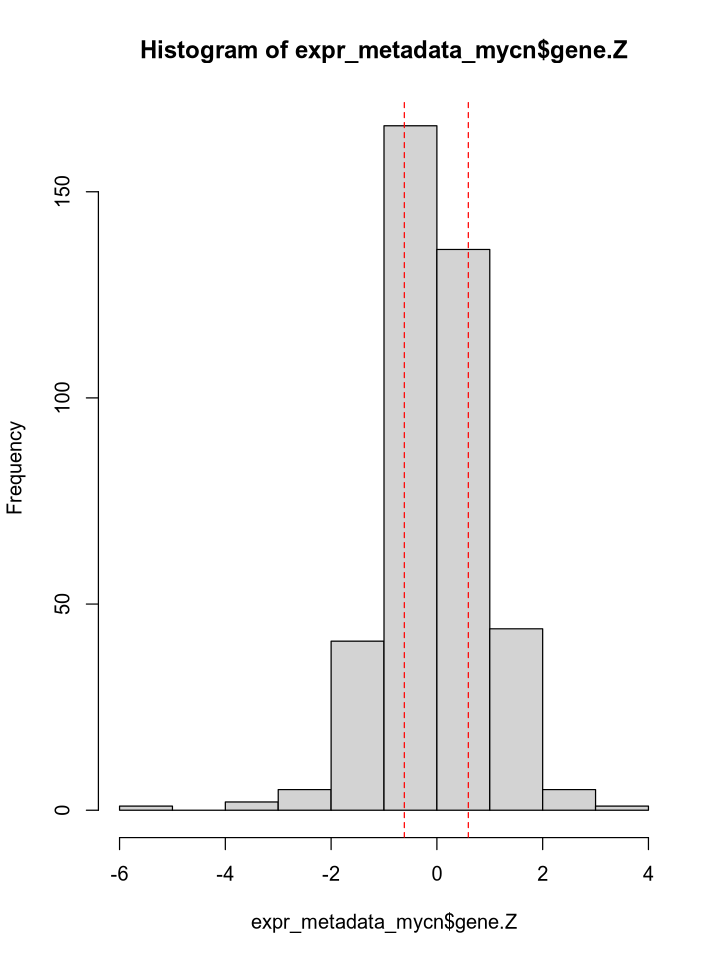

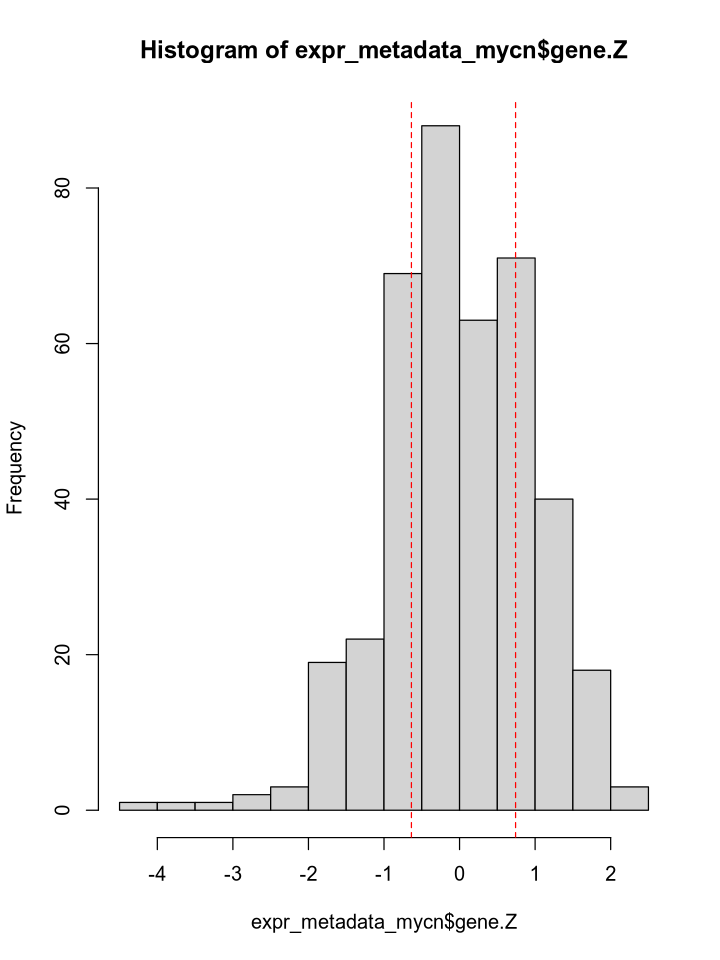

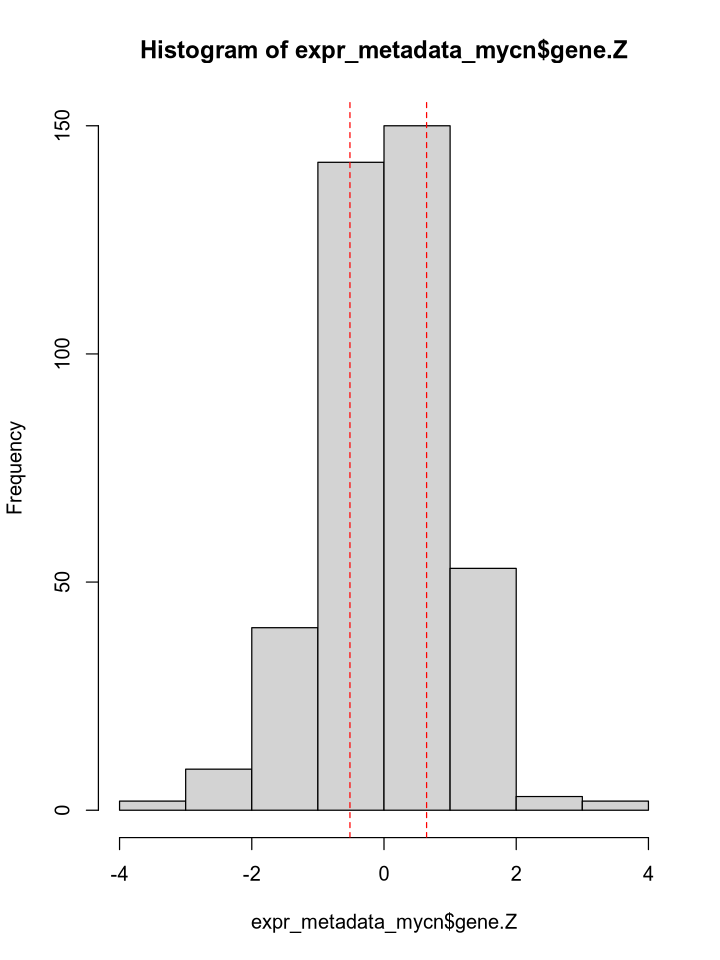

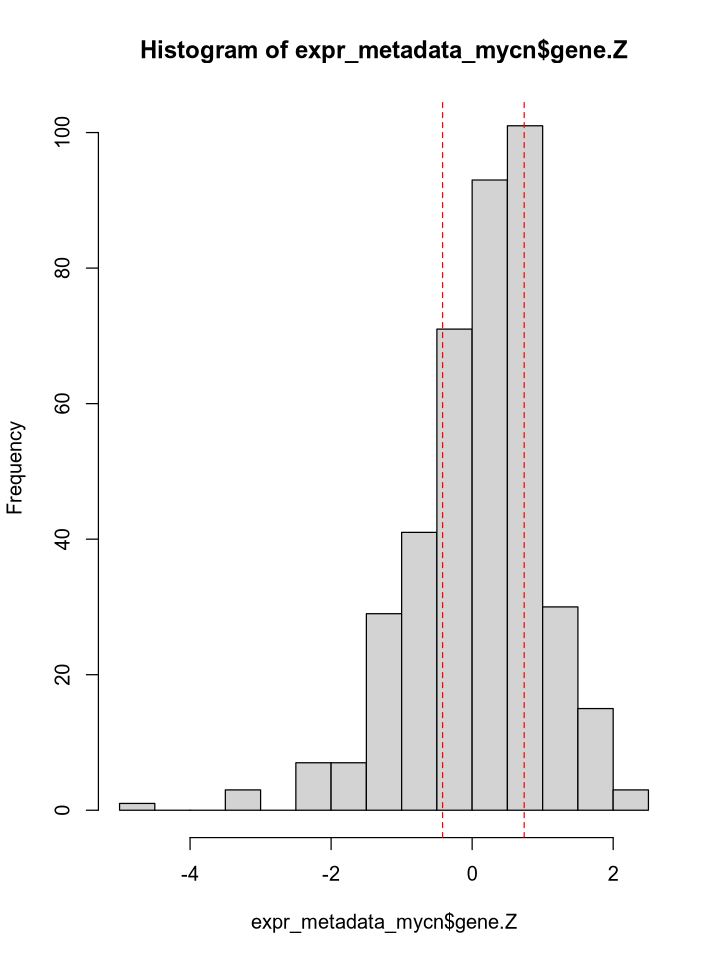

In [63]:
plot.list.no.mycn = list()

for(celltype in names(sig_groups_list)){
    plot.list.no.mycn[[celltype]] = run_surv_no_mycn(sig_groups_list[[celltype]],celltype)
}

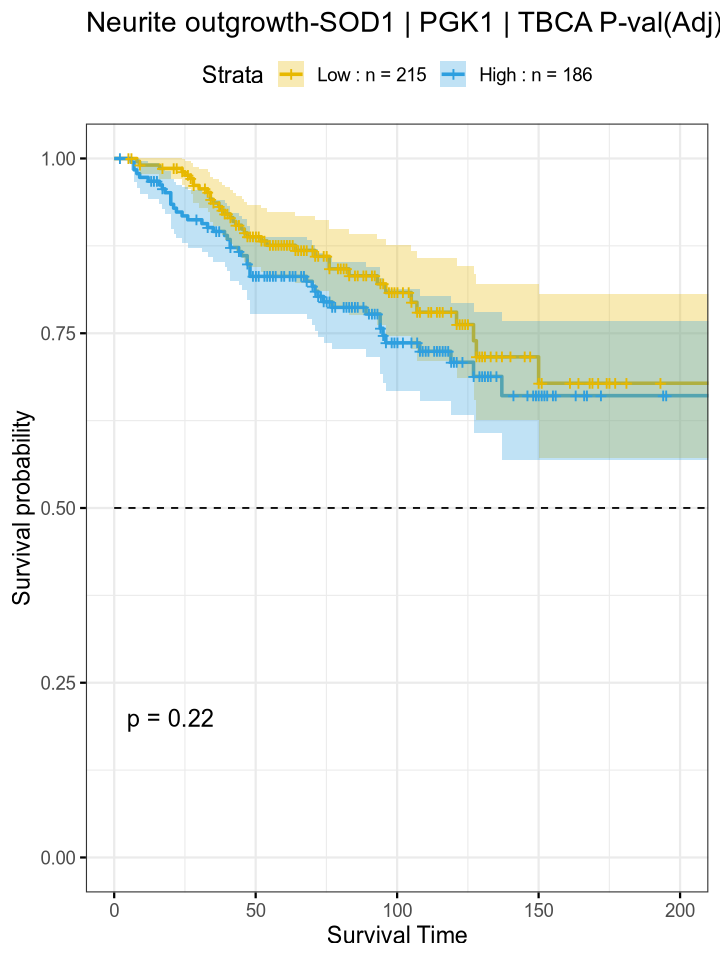

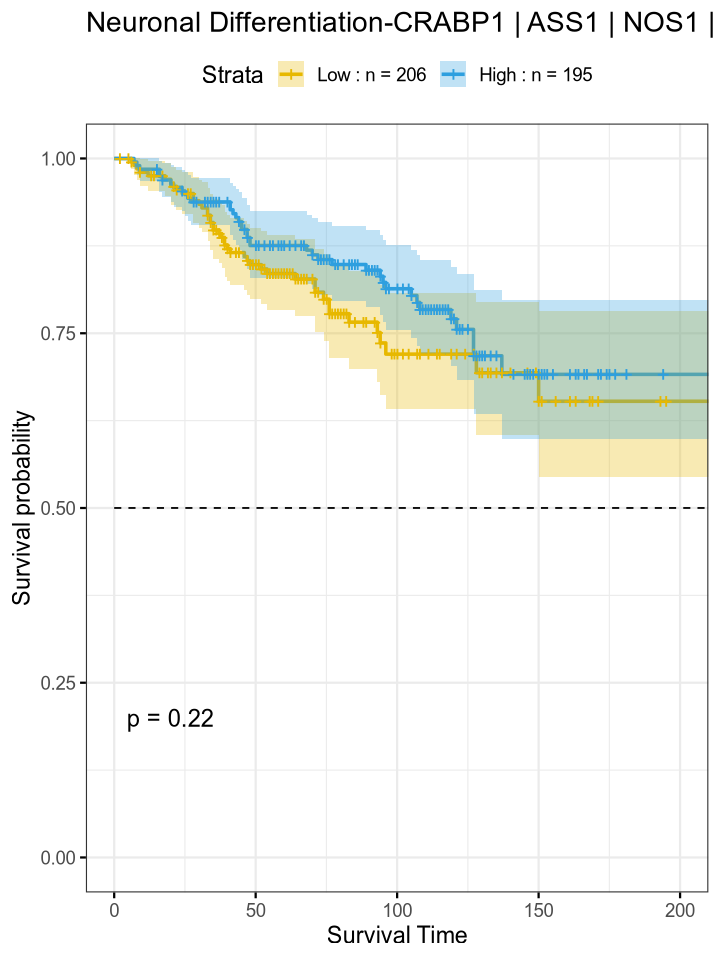

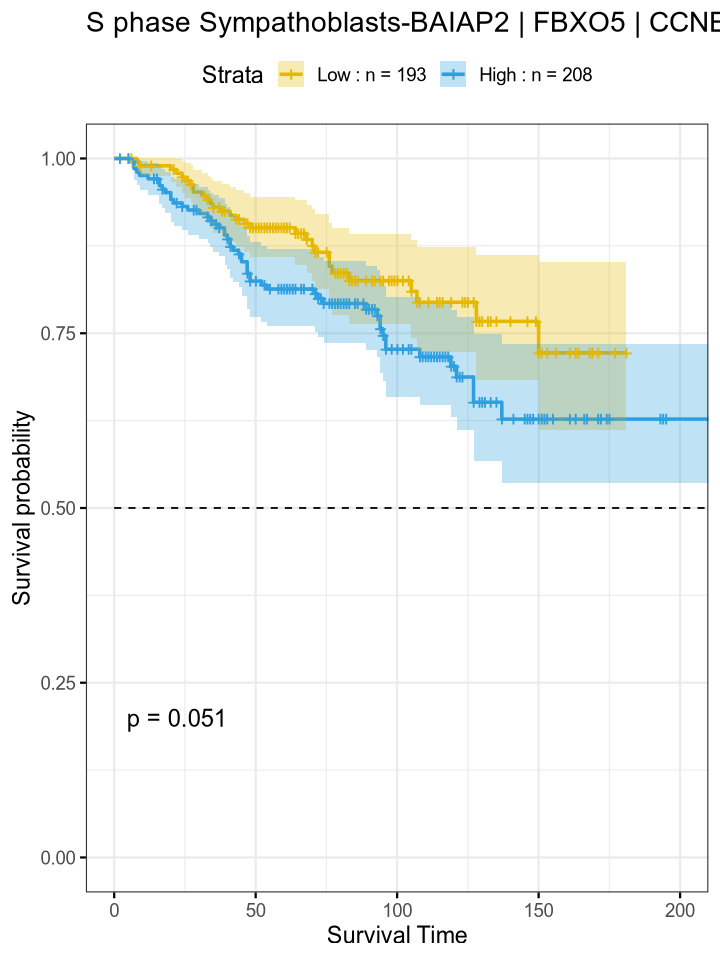

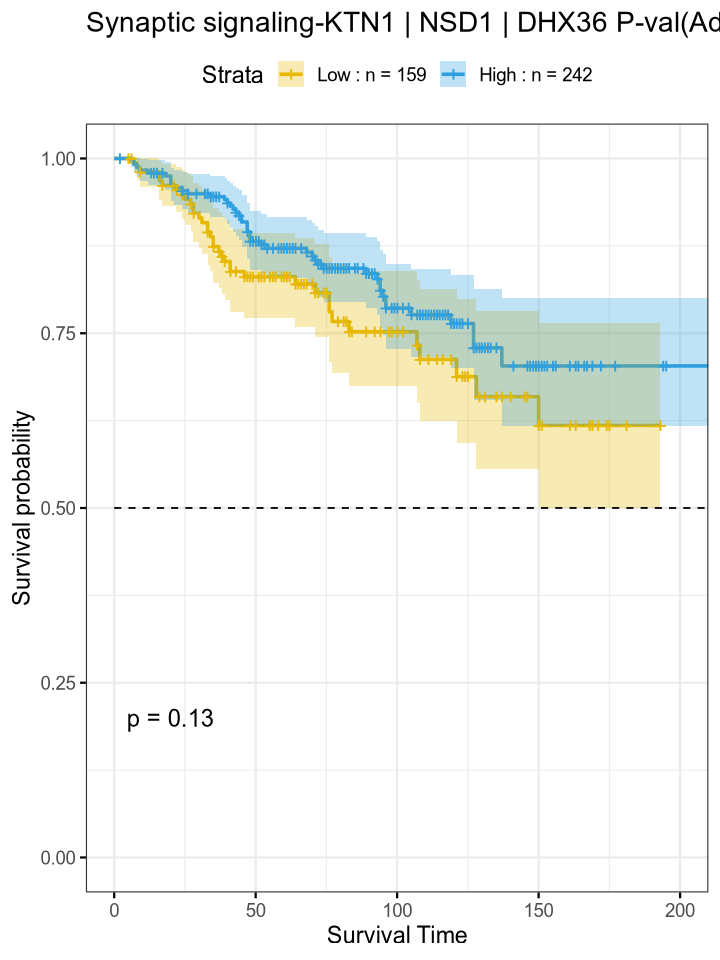

In [64]:
for (cell_type in names(plot.list.mycn)){
    print(plot.list.no.mycn[[cell_type]]$plot)
}

In [69]:
run_surv = function(
    gs,celltype
){
    gs = intersect(gs, rownames(expr_data))
    if(length(gs) == 0){
        return (NULL)
    }
    tmp = expr_data[gs,]
    score = scale(rowMeans(t(tmp)))
    expr_metadata = cbind(data.frame("gene.Z" = score), metadata)
    expr_metadata_mycn = expr_metadata
    #expr_metadata_mycn = na.omit(expr_metadata_mycn)

    ## plot histogram
    percentiles <- quantile(expr_metadata_mycn$gene.Z, probs = c(0.25, 0.75))
    hist(expr_metadata_mycn$gene.Z)
    abline(v = percentiles[1], col = "red", lty = 2)
    abline(v = percentiles[2], col = "red", lty = 2)

    expr_metadata_mycn$exprStatus <- ifelse(expr_metadata_mycn$gene.Z > 0, 1,
                                ifelse(expr_metadata_mycn$gene.Z < 0, 0, 2))

    expr_metadata_mycn <- expr_metadata_mycn[expr_metadata_mycn$exprStatus != 2,]
    expr_metadata_mycn$risk = as.numeric(expr_metadata_mycn$risk)

    # expr_metadata = expr_metadata[!is.na(expr_metadata$mycn_status),]

    fit <- do.call(survfit, list(Surv(eval(parse(text = "time")), eval(parse(text = "risk"))) ~ exprStatus, 
                                 data = expr_metadata_mycn[c("time", "risk", "exprStatus")] ))

    diff <- survdiff(formula = Surv(eval(parse(text="time")), eval(parse(text="risk"))) ~ exprStatus, 
                     data = expr_metadata_mycn[c("time", "risk", "exprStatus")]  )

    pval <- pchisq(diff$chisq, length(diff$n)-1, lower.tail = FALSE)

    adjpval <- p.adjust(pval, method = "fdr",  n = (fit$n[1] + fit$n[2]))

    plotTitle <- paste0(celltype,"-", paste(gs, collapse = " | "), " P-val(Adj) :", 
                        format(pval, scientific=T, digits=3), "(", format(adjpval, scientific=T, digits=3), ")")

    low <- paste0("Low : n = ", fit$n[1])
    high <- paste0("High : n = ", fit$n[2])
    names(fit$strata) <- c(low,high)

    fig.size(8,6)
    plot <- ggsurvplot(fit,
                 data = expr_metadata_mycn,
                 pval = TRUE,
                 pval.size = 5,
                 conf.int = TRUE,
                 risk.table = TRUE, # Add risk table
                 risk.table.col = "strata", # Change risk table color by groups
                 surv.median.line = "hv", # Specify median survival
                 ggtheme = theme_bw(base_size = 14), # Change ggplot2 theme
                 risk.table.fontsize = 5,
                 palette = c("#E7B800", "#2E9FDF"),
                 title = plotTitle) + xlab('Survival Time')
    
    ggsave(
        glue::glue(
            '/scratch/gpfs/KANG/hirak/mendel/Projects/neuroblastoma_analysis/',
            paste0('results/figures/2024/survival_plot_combined/',celltype,'.pdf')
        ),
        plot = plot$plot, 
        height = 6,
        width = 6,
        create.dir=TRUE
    )
    return(plot)
}

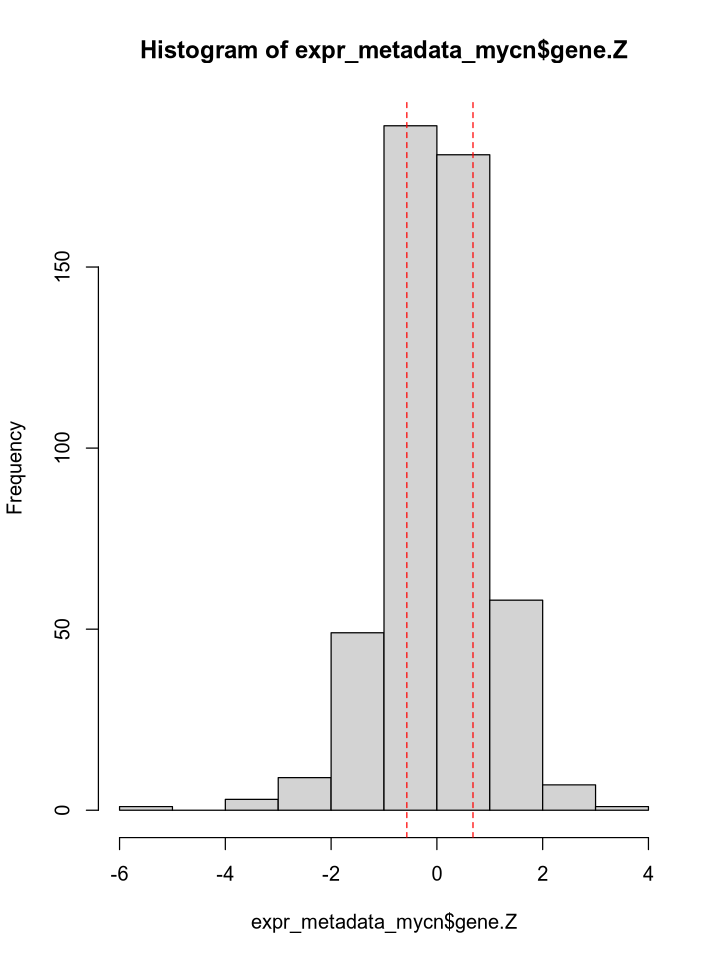

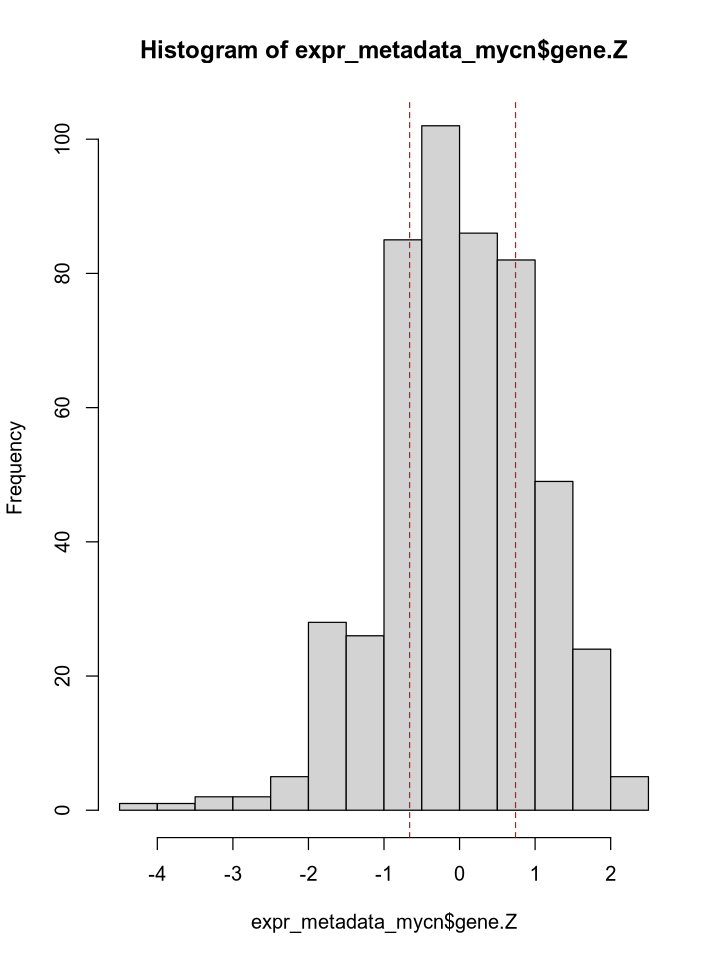

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”


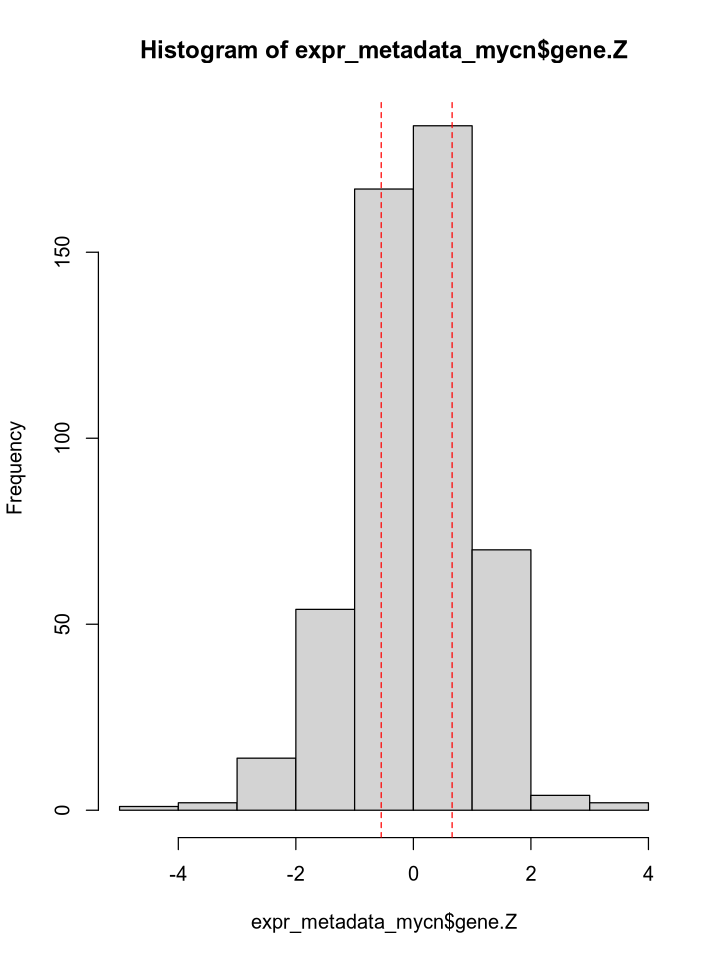

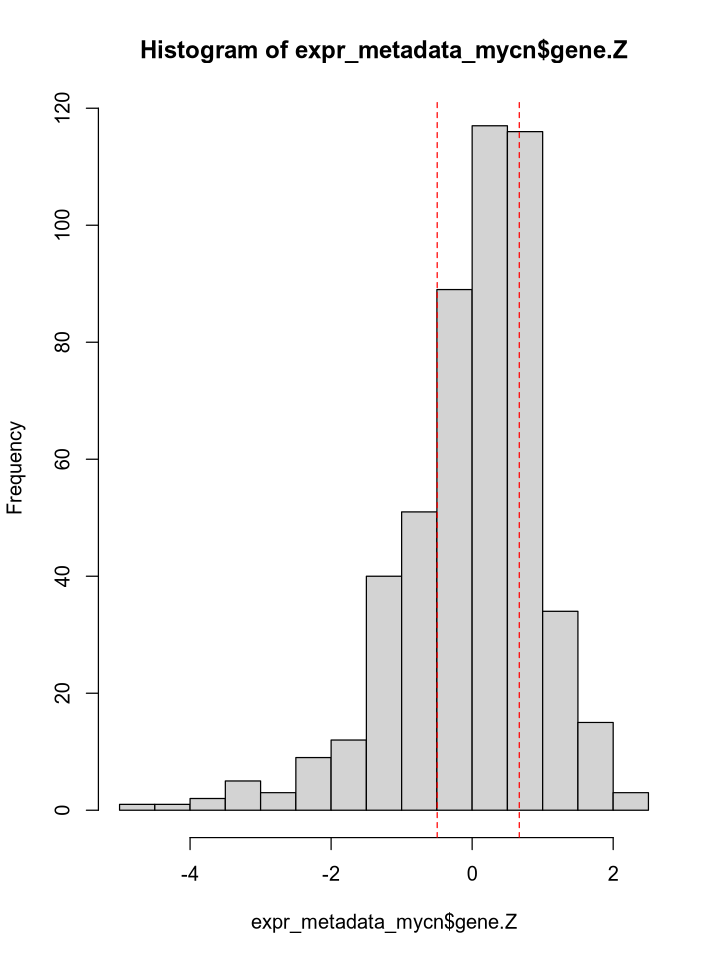

In [70]:
plot.list = list()

for(celltype in names(sig_groups_list)){
    plot.list[[celltype]] = run_surv(sig_groups_list[[celltype]],celltype)
}

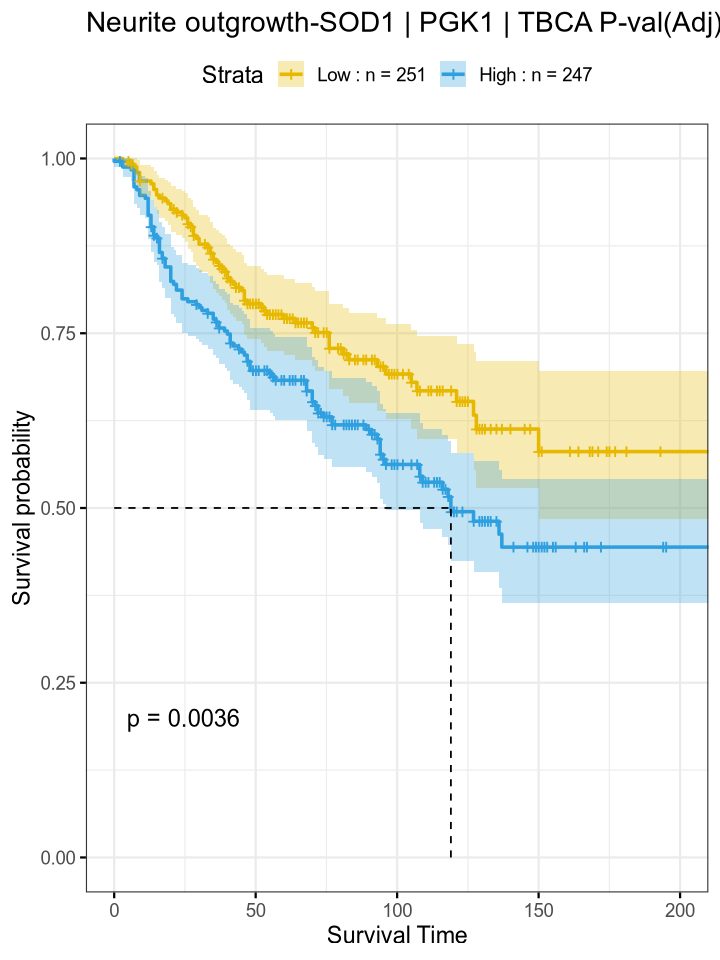

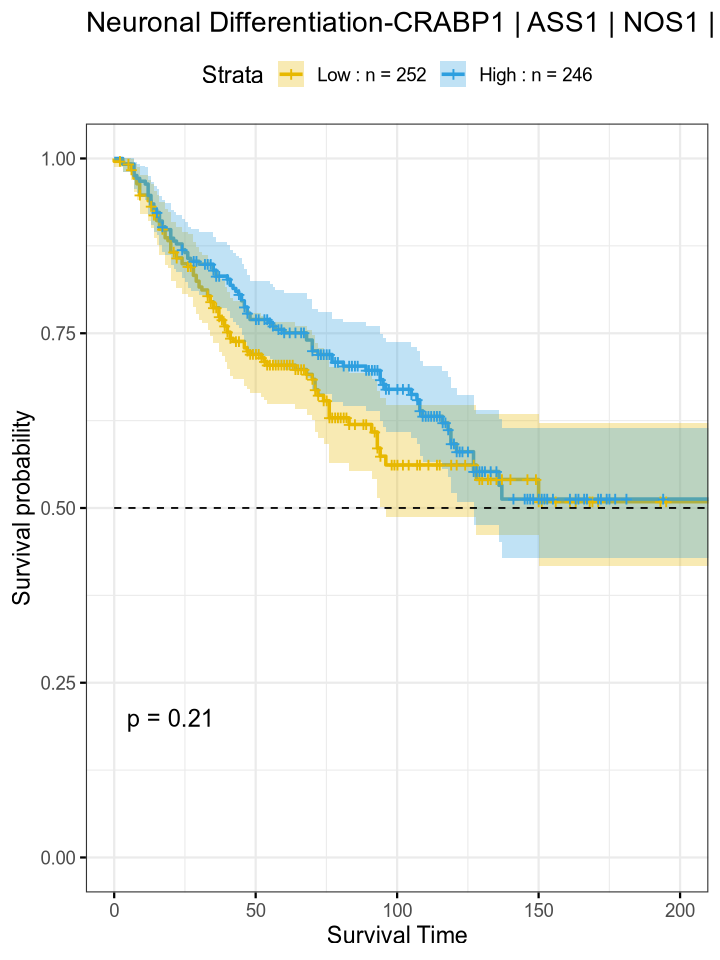

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”


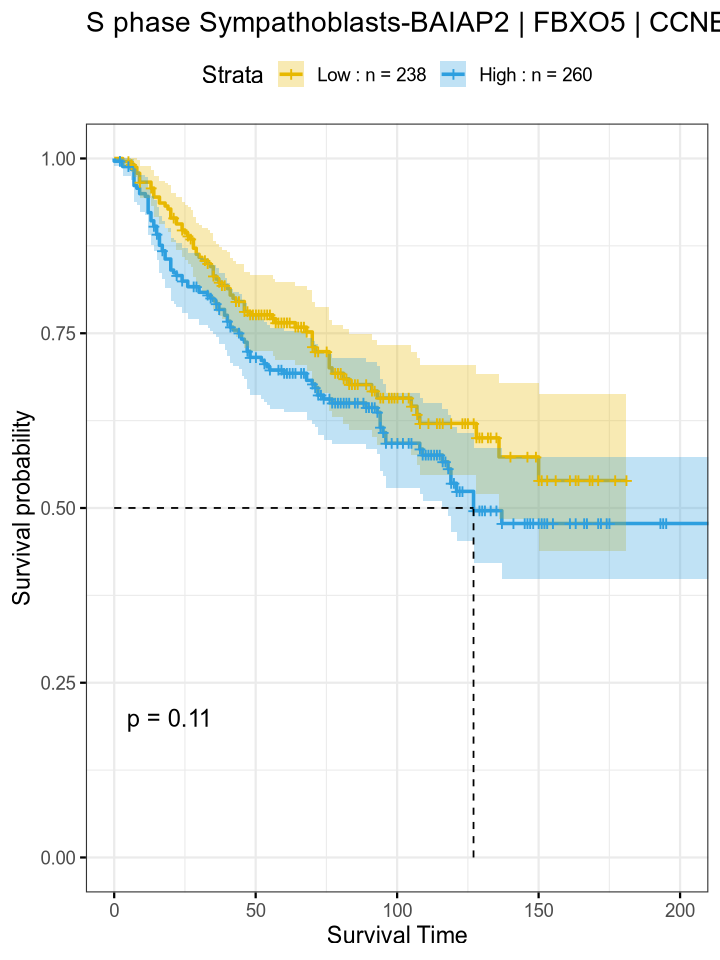

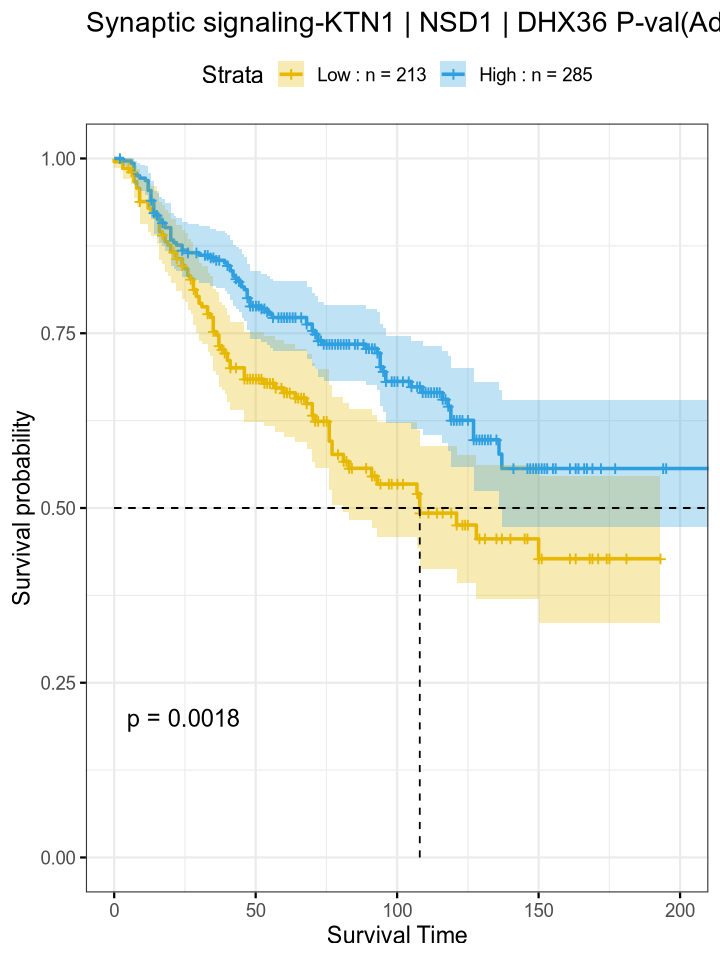

In [71]:
for (cell_type in names(plot.list.mycn)){
    print(plot.list[[cell_type]]$plot)
}

In [144]:
run_surv = function(
    gs,celltype
){
    gs = intersect(gs, rownames(expr_data))
    if(length(gs) == 0){
        return (NULL)
    }
    tmp = expr_data[gs,]
    score = scale(rowMeans(t(tmp)))
    expr_metadata = cbind(data.frame("gene.Z" = score), metadata)

    ## plot histogram
    percentiles <- quantile(expr_metadata$gene.Z, probs = c(0.25, 0.75))
    hist(expr_metadata$gene.Z)
    abline(v = percentiles[1], col = "red", lty = 2)
    abline(v = percentiles[2], col = "red", lty = 2)

    expr_metadata$exprStatus <- ifelse(expr_metadata$gene.Z > 0, 1,
                                ifelse(expr_metadata$gene.Z < 0, 0, 2))

    expr_metadata <- expr_metadata[expr_metadata$exprStatus != 2,]
    expr_metadata$mycn_status = as.numeric(expr_metadata$mycn_status)

    expr_metadata = expr_metadata[!is.na(expr_metadata$mycn_status),]

    fit <- do.call(survfit, list(Surv(eval(parse(text = "time")), eval(parse(text = "mycn_status"))) ~ exprStatus, 
                                 data = expr_metadata[c("time", "mycn_status", "exprStatus")] ))

    diff <- survdiff(formula = Surv(eval(parse(text="time")), eval(parse(text="mycn_status"))) ~ exprStatus, 
                     data = expr_metadata[c("time", "mycn_status", "exprStatus")]  )

    pval <- pchisq(diff$chisq, length(diff$n)-1, lower.tail = FALSE)

    adjpval <- p.adjust(pval, method = "fdr",  n = (fit$n[1] + fit$n[2]))

    plotTitle <- paste0(celltype,"-", paste(gs, collapse = " | "), " P-val(Adj) :", 
                        format(pval, scientific=T, digits=3), "(", format(adjpval, scientific=T, digits=3), ")")

    low <- paste0("Low : n = ", fit$n[1])
    high <- paste0("High : n = ", fit$n[2])
    names(fit$strata) <- c(low,high)

    fig.size(8,6)
    plot <- ggsurvplot(fit,
                 data = expr_metadata,
                 pval = TRUE,
                 pval.size = 5,
                 conf.int = TRUE,
                 risk.table = TRUE, # Add risk table
                 risk.table.col = "strata", # Change risk table color by groups
                 surv.median.line = "hv", # Specify median survival
                 ggtheme = theme_bw(base_size = 14), # Change ggplot2 theme
                 risk.table.fontsize = 5,
                 palette = c("#E7B800", "#2E9FDF"),
                 title = plotTitle) + xlab('Survival Time')
    
    ggsave(
        glue::glue(
            '/scratch/gpfs/KANG/hirak/mendel/Projects/neuroblastoma_analysis/',
            paste0('results/figures/2024/survival_plot/',celltype,'.pdf')
        ),
        plot = plot$plot, 
        height = 6,
        width = 6,
        create.dir=TRUE
    )
    return(plot)
}

In [24]:
signature.df = openxlsx::read.xlsx(
    '../spread_sheet/Figure5_20240214_No_6-50_Organoids_survival_signatures.xlsx'
)
sig_groups = signature.df %>% 
    group_by(Annotation) %>%
    summarize(ValueList = list(Human.Gene), .groups = 'drop')
sig_groups_list = sig_groups$ValueList
names(sig_groups_list) = sig_groups$Annotation

In [111]:
sig_groups = signature.df %>% 
    group_by(Annotation) %>%
    summarize(ValueList = list(Human.Gene), .groups = 'drop')

In [112]:
sig_groups

Annotation,ValueList
<chr>,<list>
Neurite outgrowth,"FDPS, SO...."
Neuronal Differentiation,"CRABP1, ...."
S phase Sympathoblasts,"BAIAP2, ...."
Synaptic signaling,"TSIX, KT...."


In [113]:
sig_groups_list = sig_groups$ValueList

In [114]:
names(sig_groups_list) = sig_groups$Annotation

In [115]:
sig_groups_list

$`Neurite outgrowth`
[1] "FDPS" "SOD1" "PGK1" "TBCA"

$`Neuronal Differentiation`
[1] "CRABP1" "ASS1"   "NOS1"   "HMX3"  

$`S phase Sympathoblasts`
[1] "BAIAP2" "FBXO5"  "CCNE1"  "DDIT4"  "CDKN1A"

$`Synaptic signaling`
[1] "TSIX"  "KTN1"  "NSD1"  "DHX36"

In [110]:
umap_list = list(
C1=c('Dhx36','Nsd1','Ktn1','Tsix'),
C2=c('Tbca','Pgk1','Fdps','Sod1'), 
C3=c('Fbxo5','Ccne1','Baiap2','Ddit4','Cdkn1a'),
C4=c('Ass1','Nos1','Crabp1','Hmx3')
)

Warning message in run_surv(sig_groups_list[[celltype]], celltype):
“NAs introduced by coercion”
Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Median survival not reached.”
Warning message in run_surv(sig_groups_list[[celltype]], celltype):
“NAs introduced by coercion”
Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Median survival not reached.”


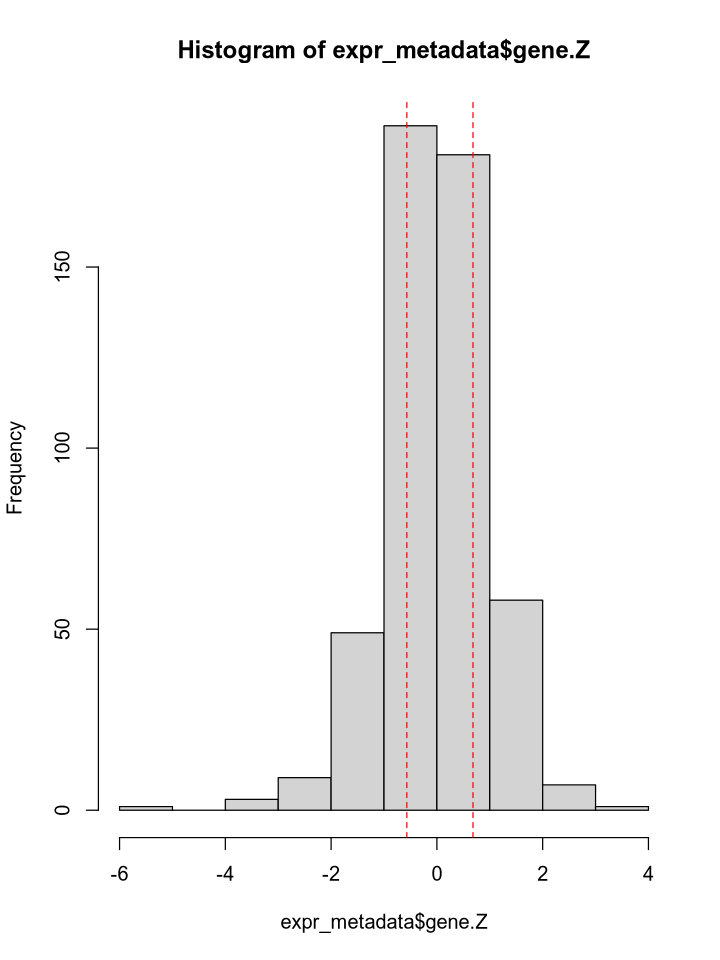

Warning message in run_surv(sig_groups_list[[celltype]], celltype):
“NAs introduced by coercion”
Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Median survival not reached.”


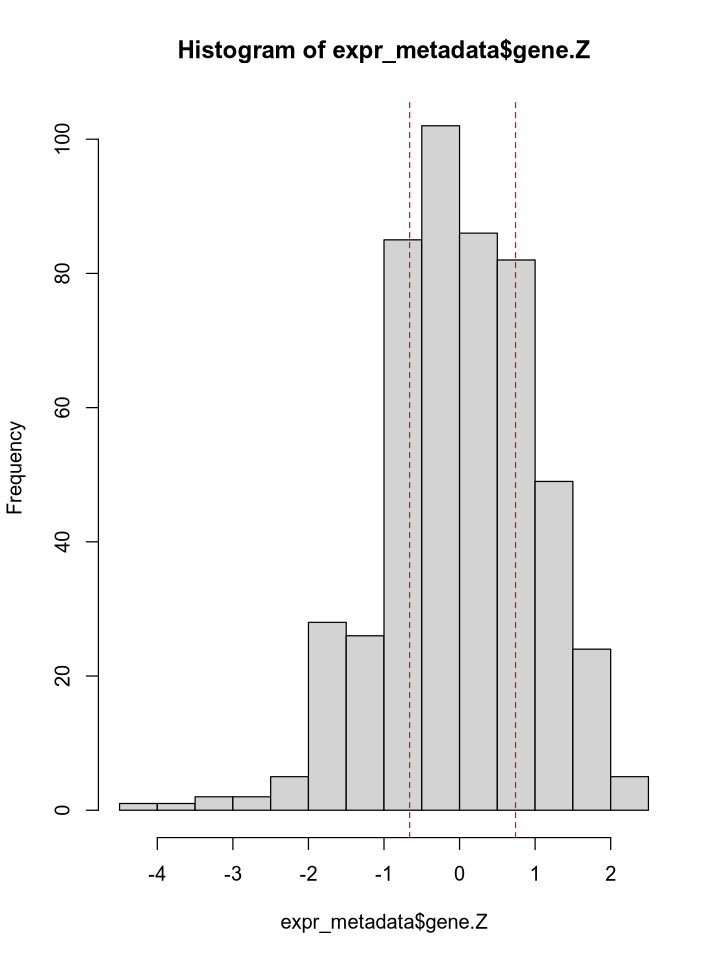

Warning message in run_surv(sig_groups_list[[celltype]], celltype):
“NAs introduced by coercion”
Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Median survival not reached.”


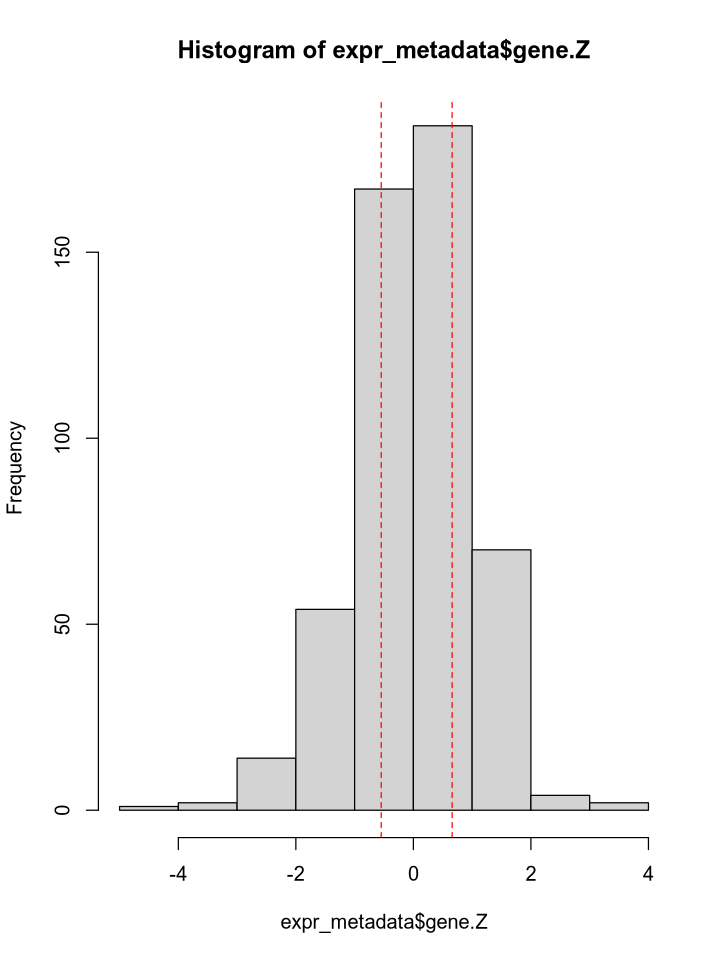

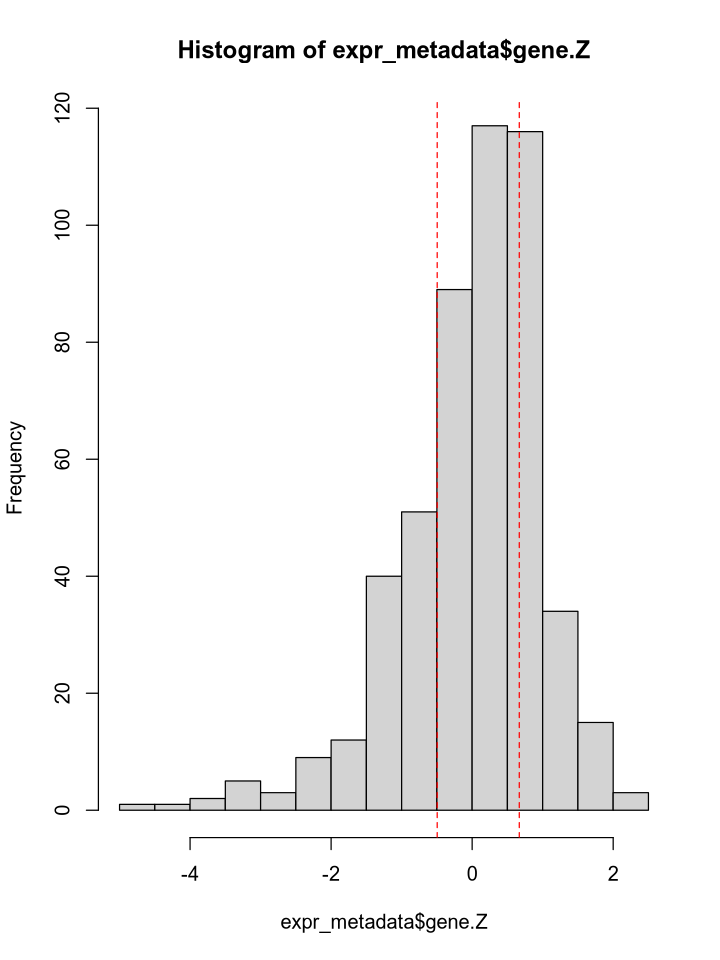

In [145]:
plot.list = list()

for(celltype in names(sig_groups_list)){
    plot.list[[celltype]] = run_surv(sig_groups_list[[celltype]],celltype)
}

In [118]:
intersect(rownames(expr_data), sig_groups_list$`Neurite outgrowth`)

[1] "PGK1" "SOD1" "TBCA"

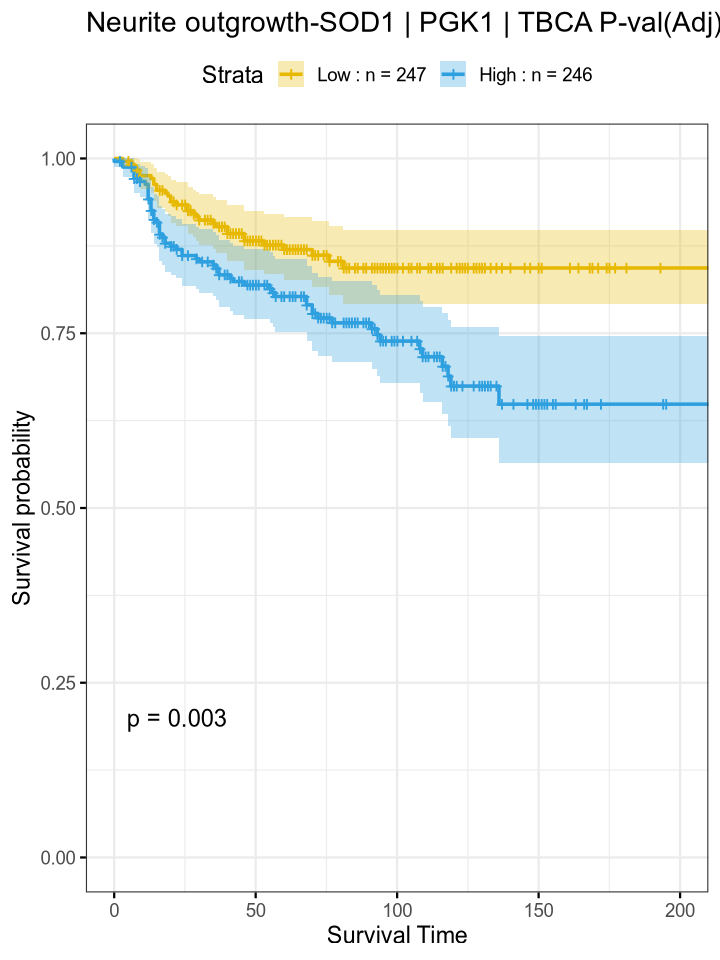

In [146]:
plot.list$`Neurite outgrowth`$plot

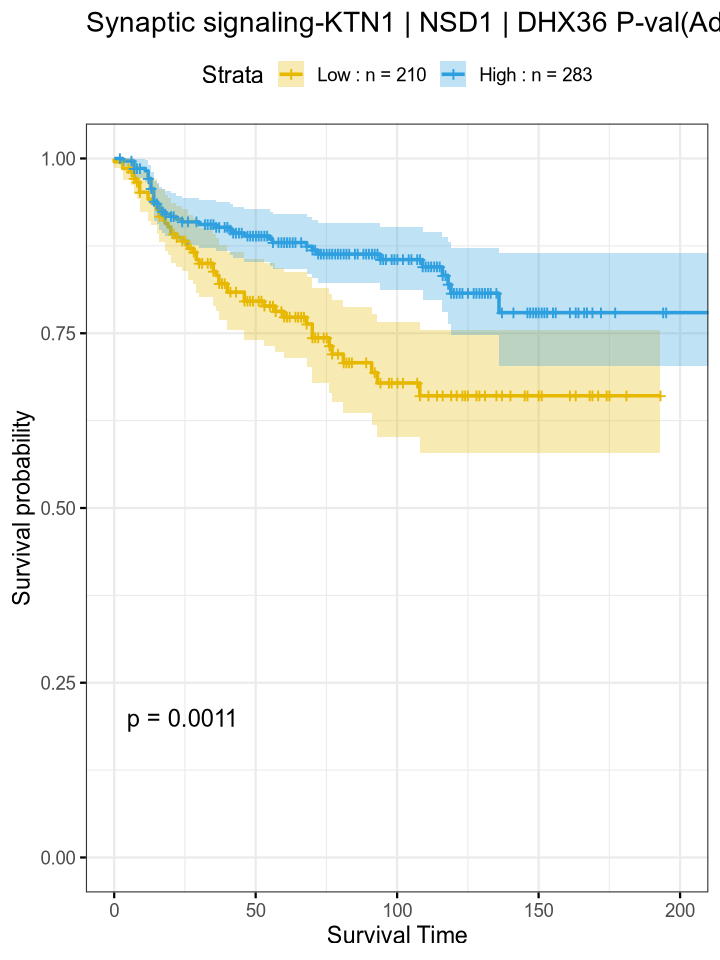

In [153]:
plot.list$`Synaptic signaling`$plot

In [131]:
library(gridExtra)

In [150]:
ps = run_surv(c('NSD1') ,'celltype')

ERROR: Error in quantile.default(expr_metadata$gene.Z, probs = c(0.25, 0.75)): missing values and NaN's not allowed if 'na.rm' is FALSE


## MyCN positive samples 

In [ ]:
mycn_meta 

In [170]:
metadata %>% filter(mycn_status)

,title,OS.days,OS.event,EFS.days,EFS.event,age,gender,time,vital_status,mycn_status,risk
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,SEQC_NB001,1362,1,593,1,987,M,45,1,0,1
2,SEQC_NB002,2836,1,2016,1,1808,M,95,1,0,1
3,SEQC_NB003,1191,1,840,1,625,F,40,1,1,1
4,SEQC_NB004,2046,0,2046,0,335,F,68,0,1,1
5,SEQC_NB005,220,1,212,1,536,F,7,1,1,1
6,SEQC_NB006,2217,0,2217,0,147,M,74,0,0,0


[1] "SOX | ERBB"

In [45]:
gs=c('SOX10','ERBB3')
tmp = expr_data[gs,]

In [49]:
score = scale(rowMeans(t(tmp)))

In [80]:
expr_metadata = cbind(data.frame("gene.Z" = score), metadata)

In [149]:
table(expr_metadata$mycn_status)


  0   1 
401  92 

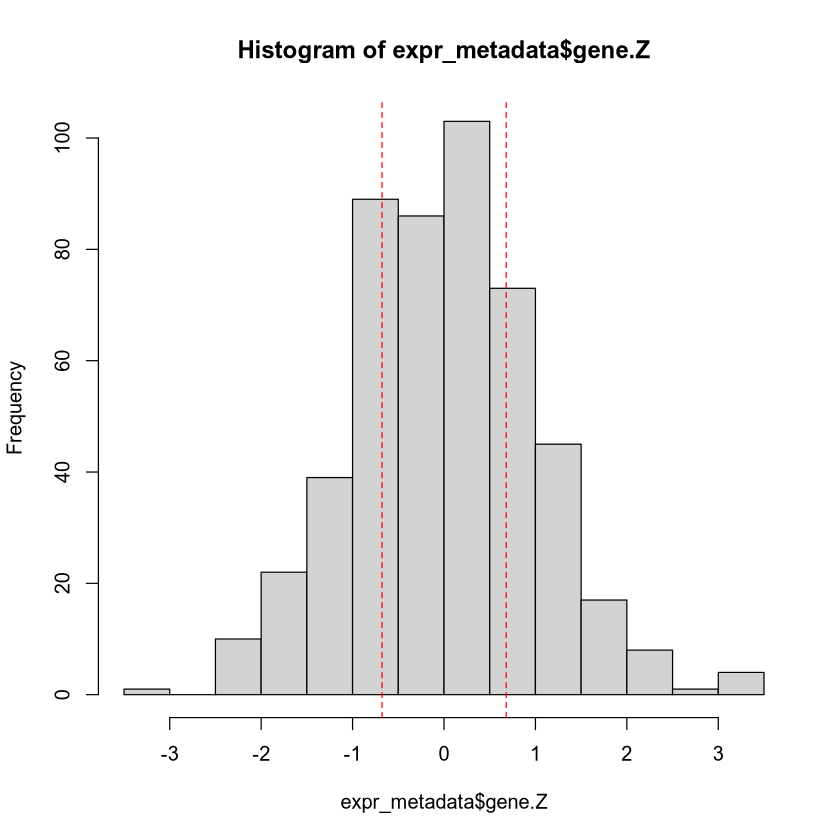

In [60]:
percentiles <- quantile(expr_metadata$gene.Z, probs = c(0.25, 0.75))
hist(expr_metadata$gene.Z)
abline(v = percentiles[1], col = "red", lty = 2)
abline(v = percentiles[2], col = "red", lty = 2)

In [82]:
expr_metadata$exprStatus <- ifelse(expr_metadata$gene.Z > 0, 1,
                                ifelse(expr_metadata$gene.Z < 0, 0, 2))

### Method from https://github.com/kpatel427/R-scripts/blob/484b3f9390ae98029bb368daa788c7cfa26bc64c/survivalAnalysis.R

In [83]:
expr_metadata[c("time", "mycn_status", "exprStatus")] %>% head

,time,mycn_status,exprStatus
,<dbl>,<chr>,<dbl>
GSM1205238,45,0,1
GSM1205239,95,0,1
GSM1205240,40,1,1
GSM1205241,68,1,0
GSM1205242,7,1,0
GSM1205243,74,0,1


In [84]:
expr_metadata$mycn_status = as.numeric(expr_metadata$mycn_status)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [90]:
expr_metadata = expr_metadata[!is.na(expr_metadata$mycn_status),]

In [91]:
fit <- do.call(survfit, list(Surv(eval(parse(text = "time")), eval(parse(text = "mycn_status"))) ~ exprStatus, data = expr_metadata[c("time", "mycn_status", "exprStatus")] ))

In [92]:
diff <- survdiff(formula = Surv(eval(parse(text="time")), eval(parse(text="mycn_status"))) ~ exprStatus, data = expr_metadata[c("time", "mycn_status", "exprStatus")]  )

In [93]:
pval <- pchisq(diff$chisq, length(diff$n)-1, lower.tail = FALSE)

adjpval <- p.adjust(pval, method = "fdr",  n = (fit$n[1] + fit$n[2]))

In [95]:
plotTitle <- paste0(paste("SOX_ERBB", collapse = " | "), " P-val(Adj) :", format(pval, scientific=T, digits=3), "(", format(adjpval, scientific=T, digits=3), ")")

In [96]:
low <- paste0("Low : n = ", fit$n[1])
high <- paste0("High : n = ", fit$n[2])
names(fit$strata) <- c(low,high)

Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Median survival not reached.”


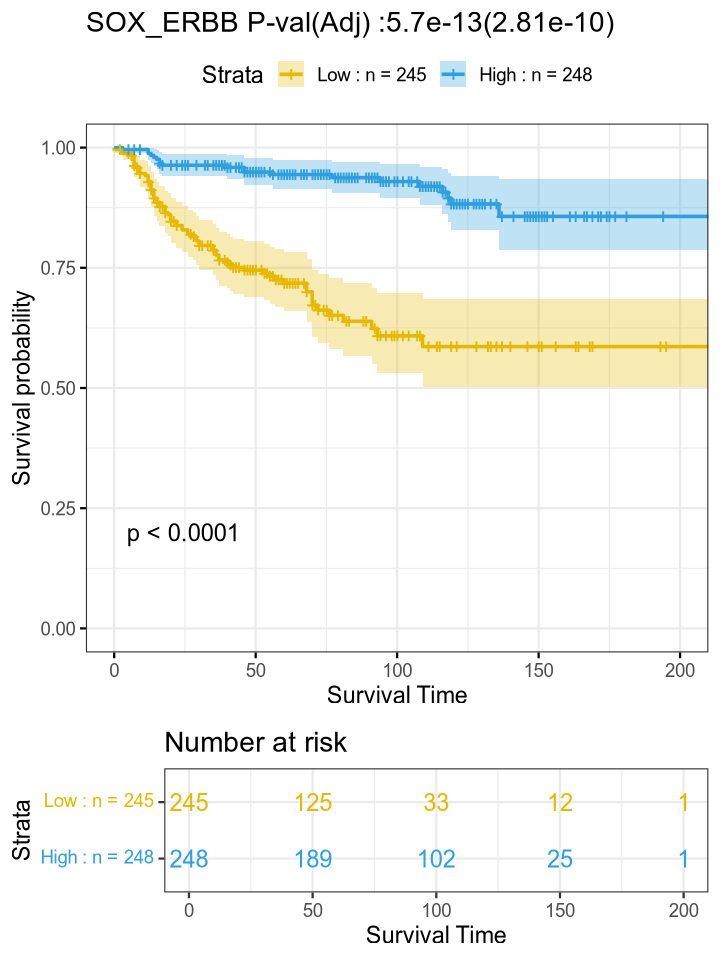

In [105]:
fig.size(8,6)
plot <- ggsurvplot(fit,
             data = expr_metadata,
             pval = TRUE,
             pval.size = 5,
             conf.int = TRUE,
             risk.table = TRUE, # Add risk table
             risk.table.col = "strata", # Change risk table color by groups
             surv.median.line = "hv", # Specify median survival
             ggtheme = theme_bw(base_size = 14), # Change ggplot2 theme
             risk.table.fontsize = 5,
             palette = c("#E7B800", "#2E9FDF"),
             title = plotTitle) + xlab('Survival Time')

plot

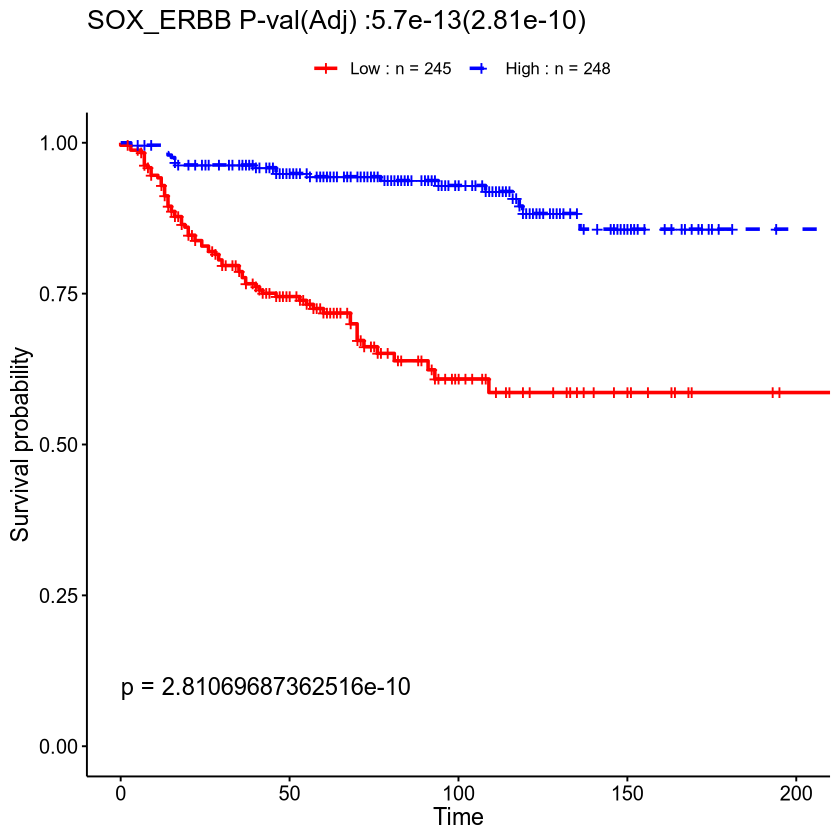

In [101]:
ggsurvplot(fit, pval = adjpval,linetype = c("solid", "dashed"), #
                palette = c("red","blue"),title=plotTitle, #paste(gs,p2),
                legend.title="", pval.coord = c(0, 0.1),
                conf.int = F) 

In [68]:
title = "SOX_ERBB"
res1 = expr_metadata$gene.Z[ expr_metadata$gene.Z >= percentiles[1] ]
res2 = expr_metadata$gene.Z[ expr_metadata$gene.Z < percentiles[2] ]
fn1 = paste(title,'-High',sep='')
fn2 = paste(title,'-Low',sep='')
res2$x=fn2
res1$x=fn1 #'High-exp'
res=rbind(res1,res2)

Warning message in res2$x = fn2:
“Coercing LHS to a list”
Warning message in res1$x = fn1:
“Coercing LHS to a list”
Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 2)”


In [69]:
res

,,,,,,,,,,,⋯,,,,,,,,,,x
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
res1,1.004522....,1.103367....,1.431531....,-0.66792....,0.707989....,0.403547....,1.324779....,1.530375....,0.166320....,1.538283....,⋯,-0.33976....,-0.62048....,-0.16184....,-0.06695....,0.055614....,-0.13416....,-0.28441....,0.229581....,0.988707....,SOX_ERBB....
res2,-0.66792....,-1.35588....,0.403547....,-0.72328....,0.166320....,0.490531....,0.458900....,0.427270....,0.561699....,-0.34767....,⋯,-1.93709....,-1.82638....,-0.80630....,-0.06695....,0.055614....,-0.13416....,-0.28441....,0.229581....,SOX_ERBB-Low,-0.66792....


In [2]:
# reading in soft file to get risk and mycn status for sample_titles
family.soft <-  read.delim("GSE49711_family.soft", header = F)
# Sample_titles
sample.title <-  as.data.frame(family.soft[ (family.soft$V1 %like% "!Sample_title" ), ])
colnames(sample.title) <- "V1"
setDT(sample.title)[, c("V1", "sample_title") := tstrsplit(sample.title$V1, "=", fixed=TRUE)]

In [3]:
# high_risk
risk <-  as.data.frame(family.soft[ (family.soft$V1 %like% "!Sample_characteristics_ch1 = high risk"), ])
colnames(risk) <- "V1"
setDT(risk)[, c("V1", "high_risk") := tstrsplit(risk$V1, ":", fixed=TRUE)]

# mycn_status
mycn_status <- as.data.frame(family.soft[ (family.soft$V1 %like% "!Sample_characteristics_ch1 = mycn status"), ])
colnames(mycn_status) <- "V1"
setDT(mycn_status)[, c("V1", "mycn_status") := tstrsplit(mycn_status$V1, ":", fixed=TRUE)]



# combining sample with mycn status and risk
sample.mycn.risk <- as.data.frame(cbind(sample.title$sample_title, mycn_status$mycn_status, risk$high_risk))
colnames(sample.mycn.risk) <-  c("Sample_title","mycn_status","high_risk")
# Sample titles were of type integer, changing to character
sample.mycn.risk$Sample_title <- as.character(sample.mycn.risk$Sample_title)
# removing blank space before the sample_title
sample.mycn.risk$Sample_title <- gsub(" ","",sample.mycn.risk$Sample_title, fixed = T)

In [4]:
soft.file = family.soft

In [8]:
soft.file[ (soft.file$V1 %like% "!Sample_characteristics_ch1 = efs day" ), ]

character(0)

In [6]:
#efs_day 
efs.day <- as.data.frame(soft.file[ (soft.file$V1 %like% "!Sample_characteristics_ch1 = efs day" ), ])
colnames(efs.day) <- "V1"
setDT(efs.day)[, c("V1", "sample_title") := tstrsplit(efs.day$V1, "=", fixed=TRUE)]
setDT(efs.day)[, c("sample_title","EFS day") := tstrsplit(efs.day$sample_title, ":", fixed=TRUE)]
efs.day <- subset(efs.day, select = c("EFS day"))



#efs_bin
efs.bin <- as.data.frame(soft.file[ (soft.file$V1 %like% "!Sample_characteristics_ch1 = efs bin" ), ])
colnames(efs.bin) <- "V1"
setDT(efs.bin)[, c("V1", "sample_title") := tstrsplit(efs.bin$V1, "=", fixed=TRUE)]
setDT(efs.bin)[, c("sample_title","EFS bin") := tstrsplit(efs.bin$sample_title, ":", fixed=TRUE)]
efs.bin <- subset(efs.bin, select = c("EFS bin"))

#os_day
os.day <- as.data.frame(soft.file[ (soft.file$V1 %like% "!Sample_characteristics_ch1 = os day" ), ])
colnames(os.day) <- "V1"
setDT(os.day)[, c("V1", "sample_title") := tstrsplit(os.day$V1, "=", fixed=TRUE)]
setDT(os.day)[, c("sample_title","OS day") := tstrsplit(os.day$sample_title, ":", fixed=TRUE)]
os.day <- subset(os.day, select = c("OS day"))


#os_bin
os.bin <- as.data.frame(soft.file[ (soft.file$V1 %like% "!Sample_characteristics_ch1 = os bin" ), ])
colnames(os.bin) <- "V1"
setDT(os.bin)[, c("V1", "sample_title") := tstrsplit(os.bin$V1, "=", fixed=TRUE)]
setDT(os.bin)[, c("sample_title","OS bin") := tstrsplit(os.bin$sample_title, ":", fixed=TRUE)]
os.bin <- subset(os.bin, select = c("OS bin"))


# high_risk
high.risk <- as.data.frame(soft.file[ (soft.file$V1 %like% "!Sample_characteristics_ch1 = high risk:" ), ])
colnames(high.risk) <- "V1"
setDT(high.risk)[, c("V1", "sample_title") := tstrsplit(high.risk$V1, "=", fixed=TRUE)]
setDT(high.risk)[, c("sample_title","High risk") := tstrsplit(high.risk$sample_title, ":", fixed=TRUE)]
high.risk <- subset(high.risk, select = c("High risk"))

# Sex
gender <- as.data.frame(soft.file[ (soft.file$V1 %like% "!Sample_characteristics_ch1 = Sex:" ), ])
colnames(gender) <- "V1"
setDT(gender)[, c("V1", "sample_title") := tstrsplit(gender$V1, "=", fixed=TRUE)]
setDT(gender)[, c("sample_title","Gender") := tstrsplit(gender$sample_title, ":", fixed=TRUE)]
gender <- subset(gender, select = c("Gender"))

ERROR: Error in `[.data.table`(setDT(efs.day), , `:=`(c("V1", "sample_title"), : Supplied 2 columns to be assigned an empty list (which may be an empty data.table or data.frame since they are lists too). To delete multiple columns use NULL instead. To add multiple empty list columns, use list(list()).
